In [2]:
import os
import keras
from scipy.io import wavfile
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from keras.layers import Conv2D, MaxPool2D, Flatten, LSTM, GRU
from keras.layers import Dropout, Dense, TimeDistributed, Bidirectional
from keras.models import Sequential
from keras.utils import to_categorical
from sklearn.utils.class_weight import compute_class_weight
from tqdm import tqdm
from python_speech_features import mfcc
import pickle
from keras.callbacks import ModelCheckpoint
from cfg import Config
from keras import optimizers
from keras import regularizers
from time import perf_counter
import tensorflow as tf

Using TensorFlow backend.


In [3]:
def check_data():
    if os.path.isfile(config.p_path):
        print('Loading existing data for {} model'.format(config.mode))
        with open(config.p_path, 'rb') as handle:
            tmp = pickle.load(handle)
            return tmp
    else:
        return None

In [4]:
def build_rand_feat():
    tmp = check_data()
    if tmp:
        return tmp.data[0], tmp.data[1]
    X = []
    y = []
    _min, _max = float('inf'), -float('inf')
    for _ in tqdm(range(n_samples)):
        rand_class = np.random.choice(class_dist.index, p=prob_dist)
        file = np.random.choice(df[df.label==rand_class].index)
        rate, wav = wavfile.read('train_files/'+file) #what if we use wavfiles/clean
        label = df.at[file, 'label']
        rand_index = np.random.randint(0, wav.shape[0]-config.step)  #random index for sampling start point      
        sample = wav[rand_index:rand_index+config.step] #sampling end after 0.1 second or 4410 index 
        X_sample = mfcc(sample, rate,numcep=config.nfeat, nfilt=config.nfilt,
                        nfft=config.nfft) #Noted that in here the ata is tranformed into MFCC type
        _min = min(np.amin(X_sample), _min)
        _max = max(np.amax(X_sample), _max)
        X.append(X_sample)
        y.append(classes.index(label))
    config.min = _min
    config.max = _max
    X, y = np.array(X), np.array(y)
    X = (X - _min) / (_max - _min)
    if config.mode == 'conv':
        X = X.reshape(X.shape[0], X.shape[1], X.shape[2], 1)
    elif config.mode == 'rnn':
        X = X.reshape(X.shape[0], X.shape[1], X.shape[2])
    elif config.mode == 'bi_rnn':
        X = X.reshape(X.shape[0], X.shape[1], X.shape[2])
    elif config.mode == 'mlp':
        X = X.reshape(X.shape[0], X.shape[1], X.shape[2])
    y = to_categorical(y, num_classes = 15)
    config.data = (X, y)
    
    with open(config.p_path, 'wb') as handle:
        pickle.dump(config, handle, protocol=2)
    
    return X, y


In [5]:
def get_conv_model():
    model = Sequential()
    model.add(Conv2D(16, (3,3), activation='relu', strides=(1,1), 
                     padding='same', input_shape=input_shape))
    model.add(Conv2D(32, (3,3), activation='relu', strides=(1,1), 
                     padding='same'))
    model.add(MaxPool2D(2,2))
    model.add(Dropout(0.2))
    model.add(Conv2D(64, (3,3), activation='relu', strides=(1,1), 
                     padding='same'))
    model.add(Conv2D(128, (3,3), activation='relu', strides=(1,1), 
                     padding='same'))
    model.add(MaxPool2D(2,2))
    model.add(Dropout(0.2))
    model.add(Flatten())
    #model.add(Dense(256, activation='relu'))
    #model.add(Dense(128, activation='relu'))
    #model.add(Dense(64, activation='relu'))
    #model.add(Dense(32, activation='relu'))
    model.add(Dense(15, activation='softmax'))
    model.summary()
    model.compile(loss='categorical_crossentropy', 
                  optimizer=keras.optimizers.Adam(lr=0.001), 
                  metrics=['acc'] )
    return model

In [6]:
###TRY USING BI-DIRECTIONAL RNN TOMORROW

def get_rnn_model():
    #shape of data for RNN is (n,time,feat)
    #NEXT TIME TRY USING GRU INSTEAD OF LSTM
    model = Sequential()
    model.add(LSTM(256, return_sequences=True, input_shape=input_shape))
    model.add(LSTM(128, return_sequences=True))
    model.add(Dropout(0.2))
    model.add(LSTM(64, return_sequences=True))
    model.add(LSTM(32, return_sequences=True))
    model.add(Dropout(0.2))
    model.add(Flatten())
    model.add(Dense(15, activation='softmax'))
    model.summary()
    model.compile(loss='categorical_crossentropy', 
                  optimizer=keras.optimizers.Adam(lr=0.001), 
                  metrics=['acc'] )
    return model

In [7]:
###TRY USING BI-DIRECTIONAL RNN TOMORROW

def get_bi_rnn_model():
    #shape of data for RNN is (n,time,feat)
    #NEXT TIME TRY USING GRU INSTEAD OF LSTM
    model = Sequential()
    model.add(Bidirectional(LSTM(128, return_sequences=True, input_shape=input_shape)))
    model.add(Bidirectional(LSTM(64, return_sequences=True)))
    model.add(Dropout(0.2))
    model.add(Bidirectional(LSTM(32, return_sequences=True)))
    model.add(Bidirectional(LSTM(16, return_sequences=True)))
    model.add(Dropout(0.2))
    model.add(Flatten())
    model.add(Dense(15, activation='softmax'))
    #model.summary()
    model.compile(loss='categorical_crossentropy', 
                  optimizer=keras.optimizers.Adam(lr=0.001), 
                  metrics=['acc'] )
    return model

In [8]:
def get_mlp_model():
    #shape of data for RNN is (n,time,feat)
    #NEXT TIME TRY USING GRU INSTEAD OF LSTM
    model = Sequential()
    model.add(Flatten())
    model.add(Dense(256, activation='relu'))
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(128, activation='relu'))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(15, activation='softmax'))
    #model.summary()
    #sgd = optimizers.SGD(lr=0.1)
    model.compile(loss='categorical_crossentropy', 
                  optimizer=keras.optimizers.Adam(lr=0.0015), 
                  metrics=['acc'] )
    return model

In [9]:
df = pd.read_csv('C:/Users/hp/Desktop/Audio-Classification-v5/train_sound.csv')
df.set_index('fname', inplace=True)

for f in df.index:
    rate, signal = wavfile.read('train_files/'+f) #interchangeable wavfiles/clean
    df.at[f, 'length'] = signal.shape[0]/rate

classes = list(np.unique(df.label))
class_dist = df.groupby(['label'])['length'].mean()

n_samples = 2 * int(df['length'].sum()/0.1) 
#we sample through 0.1 s of each audio, 
#We use the factor 2 to avoid moving exactly after 0.1s to the next 0.1s directly 
#Instead, take a 0.05s step forward and then sample the next 0.1s from that point
#It means that the second half of the last sample becomes the first half 
#of the next sample. E.g; first sample time range: 0.1s to 0.2s, 
#second sample time range: 0.15s to 0.25s
 
prob_dist = class_dist / class_dist.sum()
choices = np.random.choice(class_dist.index, p=prob_dist)

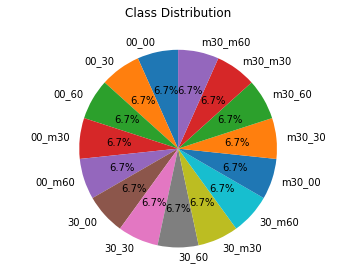

In [10]:
fig, ax = plt.subplots()
ax.set_title('Class Distribution', y=1.08)
ax.pie(class_dist, labels=class_dist.index, autopct='%1.1f%%',
       shadow=False, startangle=90)
ax.axis('equal')
plt.show()

Loading existing data for bi_rnn model
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.
Train on 48600 samples, validate on 5400 samples
Epoch 1/100
48600/48600 [==============================] - ETA: 1:53:30 - loss: 2.7082 - acc: 0.06 - ETA: 57:49 - loss: 2.7081 - acc: 0.0700 - ETA: 39:17 - loss: 2.7134 - acc: 0.06 - ETA: 29:54 - loss: 2.7149 - acc: 0.06 - ETA: 24:17 - loss: 2.7140 - acc: 0.06 - ETA: 20:37 - loss: 2.7150 - acc: 0.06 - ETA: 17:56 - loss: 2.7121 - acc: 0.07 - ETA: 15:54 - loss: 2.7108 - acc: 0.07 - ETA: 14:21 - loss: 2.7099 - acc: 0.07 - ETA: 13:06 - loss: 2.7088 - acc: 0.07 - ETA: 12:03 - loss: 2.7073 - acc: 0.07 - ETA: 11:12 - loss: 2.7049 - acc: 0.08 - ETA: 10:29 - loss: 2.7030 - acc: 0.08 - ETA: 9:51 - loss: 2.7007 - acc: 0.0867 - ETA: 9:18 - loss: 2.6981 - acc: 0.091 - ETA: 8:50 - l

48600/48600 [==============================] - ETA: 2:46 - loss: 1.2475 - acc: 0.450 - ETA: 2:52 - loss: 1.2163 - acc: 0.478 - ETA: 2:56 - loss: 1.2136 - acc: 0.472 - ETA: 2:54 - loss: 1.2380 - acc: 0.450 - ETA: 2:55 - loss: 1.2381 - acc: 0.454 - ETA: 2:54 - loss: 1.2373 - acc: 0.451 - ETA: 2:50 - loss: 1.2442 - acc: 0.446 - ETA: 2:50 - loss: 1.2471 - acc: 0.448 - ETA: 2:52 - loss: 1.2482 - acc: 0.442 - ETA: 2:49 - loss: 1.2584 - acc: 0.435 - ETA: 2:47 - loss: 1.3090 - acc: 0.417 - ETA: 2:47 - loss: 1.3282 - acc: 0.412 - ETA: 2:46 - loss: 1.3213 - acc: 0.416 - ETA: 2:44 - loss: 1.3275 - acc: 0.413 - ETA: 2:44 - loss: 1.3203 - acc: 0.417 - ETA: 2:42 - loss: 1.3353 - acc: 0.410 - ETA: 2:40 - loss: 1.3513 - acc: 0.404 - ETA: 2:39 - loss: 1.3476 - acc: 0.404 - ETA: 2:40 - loss: 1.3593 - acc: 0.400 - ETA: 2:38 - loss: 1.3572 - acc: 0.400 - ETA: 2:37 - loss: 1.3584 - acc: 0.399 - ETA: 2:37 - loss: 1.3526 - acc: 0.399 - ETA: 2:36 - loss: 1.3525 - acc: 0.398 - ETA: 2:35 - loss: 1.3495 - acc: 0

48600/48600 [==============================] - ETA: 3:15 - loss: 1.2155 - acc: 0.430 - ETA: 2:58 - loss: 1.2040 - acc: 0.456 - ETA: 2:58 - loss: 1.2413 - acc: 0.436 - ETA: 2:56 - loss: 1.2331 - acc: 0.440 - ETA: 2:51 - loss: 1.2107 - acc: 0.460 - ETA: 2:49 - loss: 1.2178 - acc: 0.450 - ETA: 2:51 - loss: 1.2175 - acc: 0.450 - ETA: 2:47 - loss: 1.2174 - acc: 0.450 - ETA: 2:44 - loss: 1.2175 - acc: 0.448 - ETA: 2:44 - loss: 1.2205 - acc: 0.449 - ETA: 2:43 - loss: 1.2235 - acc: 0.449 - ETA: 2:40 - loss: 1.2226 - acc: 0.452 - ETA: 2:39 - loss: 1.2164 - acc: 0.455 - ETA: 2:40 - loss: 1.2113 - acc: 0.459 - ETA: 2:38 - loss: 1.2107 - acc: 0.455 - ETA: 2:36 - loss: 1.2065 - acc: 0.456 - ETA: 2:36 - loss: 1.2067 - acc: 0.457 - ETA: 2:34 - loss: 1.2047 - acc: 0.457 - ETA: 2:33 - loss: 1.2010 - acc: 0.459 - ETA: 2:33 - loss: 1.2005 - acc: 0.459 - ETA: 2:31 - loss: 1.1998 - acc: 0.460 - ETA: 2:29 - loss: 1.1995 - acc: 0.460 - ETA: 2:28 - loss: 1.1986 - acc: 0.460 - ETA: 2:28 - loss: 1.1948 - acc: 0

48600/48600 [==============================] - ETA: 3:07 - loss: 1.3060 - acc: 0.433 - ETA: 2:59 - loss: 1.2456 - acc: 0.458 - ETA: 2:56 - loss: 1.2386 - acc: 0.474 - ETA: 2:59 - loss: 1.2260 - acc: 0.475 - ETA: 2:56 - loss: 1.2193 - acc: 0.474 - ETA: 2:53 - loss: 1.2102 - acc: 0.477 - ETA: 2:55 - loss: 1.2034 - acc: 0.478 - ETA: 2:53 - loss: 1.2011 - acc: 0.478 - ETA: 2:50 - loss: 1.2019 - acc: 0.475 - ETA: 2:50 - loss: 1.2068 - acc: 0.473 - ETA: 2:50 - loss: 1.2063 - acc: 0.471 - ETA: 2:48 - loss: 1.2026 - acc: 0.470 - ETA: 2:47 - loss: 1.2033 - acc: 0.468 - ETA: 2:46 - loss: 1.2006 - acc: 0.472 - ETA: 2:44 - loss: 1.1966 - acc: 0.473 - ETA: 2:44 - loss: 1.1907 - acc: 0.475 - ETA: 2:43 - loss: 1.1883 - acc: 0.475 - ETA: 2:41 - loss: 1.1874 - acc: 0.476 - ETA: 2:39 - loss: 1.1868 - acc: 0.475 - ETA: 2:38 - loss: 1.1854 - acc: 0.475 - ETA: 2:36 - loss: 1.1824 - acc: 0.477 - ETA: 2:34 - loss: 1.1803 - acc: 0.478 - ETA: 2:34 - loss: 1.1812 - acc: 0.479 - ETA: 2:32 - loss: 1.1814 - acc: 0

48600/48600 [==============================] - ETA: 2:46 - loss: 1.2058 - acc: 0.463 - ETA: 2:38 - loss: 1.2472 - acc: 0.441 - ETA: 2:44 - loss: 1.2141 - acc: 0.463 - ETA: 2:45 - loss: 1.2279 - acc: 0.454 - ETA: 2:41 - loss: 1.2088 - acc: 0.462 - ETA: 2:41 - loss: 1.2024 - acc: 0.455 - ETA: 2:43 - loss: 1.1954 - acc: 0.455 - ETA: 2:40 - loss: 1.1887 - acc: 0.460 - ETA: 2:39 - loss: 1.1815 - acc: 0.464 - ETA: 2:41 - loss: 1.1791 - acc: 0.464 - ETA: 2:40 - loss: 1.1732 - acc: 0.463 - ETA: 2:39 - loss: 1.1656 - acc: 0.466 - ETA: 2:39 - loss: 1.1615 - acc: 0.467 - ETA: 2:38 - loss: 1.1605 - acc: 0.466 - ETA: 2:37 - loss: 1.1562 - acc: 0.470 - ETA: 2:37 - loss: 1.1577 - acc: 0.472 - ETA: 2:35 - loss: 1.1550 - acc: 0.473 - ETA: 2:33 - loss: 1.1511 - acc: 0.476 - ETA: 2:32 - loss: 1.1486 - acc: 0.478 - ETA: 2:32 - loss: 1.1474 - acc: 0.478 - ETA: 2:30 - loss: 1.1479 - acc: 0.477 - ETA: 2:28 - loss: 1.1494 - acc: 0.475 - ETA: 2:29 - loss: 1.1461 - acc: 0.478 - ETA: 2:28 - loss: 1.1470 - acc: 0

48600/48600 [==============================] - ETA: 2:27 - loss: 1.2452 - acc: 0.443 - ETA: 2:31 - loss: 1.2280 - acc: 0.443 - ETA: 2:36 - loss: 1.2210 - acc: 0.445 - ETA: 2:38 - loss: 1.1958 - acc: 0.461 - ETA: 2:36 - loss: 1.1956 - acc: 0.458 - ETA: 2:36 - loss: 1.1821 - acc: 0.465 - ETA: 2:38 - loss: 1.1793 - acc: 0.465 - ETA: 2:35 - loss: 1.1774 - acc: 0.464 - ETA: 2:35 - loss: 1.1790 - acc: 0.464 - ETA: 2:36 - loss: 1.1755 - acc: 0.467 - ETA: 2:34 - loss: 1.1692 - acc: 0.472 - ETA: 2:32 - loss: 1.1706 - acc: 0.469 - ETA: 2:32 - loss: 1.1719 - acc: 0.470 - ETA: 2:31 - loss: 1.1645 - acc: 0.475 - ETA: 2:29 - loss: 1.1656 - acc: 0.474 - ETA: 2:28 - loss: 1.1643 - acc: 0.475 - ETA: 2:28 - loss: 1.1679 - acc: 0.473 - ETA: 2:27 - loss: 1.1664 - acc: 0.475 - ETA: 2:26 - loss: 1.1692 - acc: 0.475 - ETA: 2:25 - loss: 1.1634 - acc: 0.478 - ETA: 2:24 - loss: 1.1714 - acc: 0.475 - ETA: 2:23 - loss: 1.1695 - acc: 0.477 - ETA: 2:21 - loss: 1.1658 - acc: 0.479 - ETA: 2:21 - loss: 1.1640 - acc: 0

48600/48600 [==============================] - ETA: 3:11 - loss: 1.1308 - acc: 0.493 - ETA: 2:47 - loss: 1.1582 - acc: 0.483 - ETA: 2:44 - loss: 1.1802 - acc: 0.498 - ETA: 2:46 - loss: 1.1734 - acc: 0.499 - ETA: 2:44 - loss: 1.1966 - acc: 0.484 - ETA: 2:41 - loss: 1.1897 - acc: 0.480 - ETA: 2:41 - loss: 1.1833 - acc: 0.481 - ETA: 2:40 - loss: 1.2020 - acc: 0.470 - ETA: 2:38 - loss: 1.2297 - acc: 0.468 - ETA: 2:37 - loss: 1.2528 - acc: 0.465 - ETA: 2:37 - loss: 1.2574 - acc: 0.463 - ETA: 2:35 - loss: 1.2740 - acc: 0.458 - ETA: 2:34 - loss: 1.2798 - acc: 0.454 - ETA: 2:33 - loss: 1.2877 - acc: 0.449 - ETA: 2:32 - loss: 1.3043 - acc: 0.440 - ETA: 2:31 - loss: 1.2982 - acc: 0.440 - ETA: 2:30 - loss: 1.3060 - acc: 0.436 - ETA: 2:29 - loss: 1.3040 - acc: 0.435 - ETA: 2:28 - loss: 1.3067 - acc: 0.433 - ETA: 2:27 - loss: 1.3012 - acc: 0.434 - ETA: 2:26 - loss: 1.3018 - acc: 0.432 - ETA: 2:25 - loss: 1.3006 - acc: 0.429 - ETA: 2:24 - loss: 1.2946 - acc: 0.432 - ETA: 2:23 - loss: 1.2917 - acc: 0

48600/48600 [==============================] - ETA: 2:51 - loss: 1.0688 - acc: 0.543 - ETA: 2:40 - loss: 1.0572 - acc: 0.545 - ETA: 2:39 - loss: 1.0337 - acc: 0.545 - ETA: 2:43 - loss: 1.0455 - acc: 0.538 - ETA: 2:40 - loss: 1.0432 - acc: 0.544 - ETA: 2:39 - loss: 1.0357 - acc: 0.535 - ETA: 2:39 - loss: 1.0259 - acc: 0.540 - ETA: 2:39 - loss: 1.0284 - acc: 0.535 - ETA: 2:36 - loss: 1.0274 - acc: 0.532 - ETA: 2:35 - loss: 1.0193 - acc: 0.538 - ETA: 2:37 - loss: 1.0163 - acc: 0.540 - ETA: 2:37 - loss: 1.0172 - acc: 0.538 - ETA: 2:36 - loss: 1.0075 - acc: 0.543 - ETA: 2:37 - loss: 0.9994 - acc: 0.547 - ETA: 2:35 - loss: 0.9946 - acc: 0.549 - ETA: 2:34 - loss: 0.9956 - acc: 0.548 - ETA: 2:34 - loss: 1.0037 - acc: 0.546 - ETA: 2:32 - loss: 1.0164 - acc: 0.541 - ETA: 2:30 - loss: 1.0299 - acc: 0.537 - ETA: 2:30 - loss: 1.0362 - acc: 0.534 - ETA: 2:28 - loss: 1.0439 - acc: 0.530 - ETA: 2:27 - loss: 1.0510 - acc: 0.528 - ETA: 2:26 - loss: 1.0509 - acc: 0.528 - ETA: 2:25 - loss: 1.0552 - acc: 0

48600/48600 [==============================] - ETA: 2:59 - loss: 1.0887 - acc: 0.540 - ETA: 2:43 - loss: 1.0953 - acc: 0.518 - ETA: 2:41 - loss: 1.1027 - acc: 0.503 - ETA: 2:46 - loss: 1.0962 - acc: 0.514 - ETA: 2:44 - loss: 1.0899 - acc: 0.509 - ETA: 2:41 - loss: 1.0868 - acc: 0.511 - ETA: 2:40 - loss: 1.0793 - acc: 0.514 - ETA: 2:40 - loss: 1.0754 - acc: 0.518 - ETA: 2:38 - loss: 1.0797 - acc: 0.516 - ETA: 2:37 - loss: 1.0869 - acc: 0.512 - ETA: 2:37 - loss: 1.0793 - acc: 0.517 - ETA: 2:35 - loss: 1.0819 - acc: 0.516 - ETA: 2:34 - loss: 1.0764 - acc: 0.521 - ETA: 2:34 - loss: 1.0718 - acc: 0.522 - ETA: 2:32 - loss: 1.0659 - acc: 0.524 - ETA: 2:30 - loss: 1.0665 - acc: 0.525 - ETA: 2:30 - loss: 1.0685 - acc: 0.524 - ETA: 2:29 - loss: 1.0689 - acc: 0.524 - ETA: 2:27 - loss: 1.0666 - acc: 0.524 - ETA: 2:26 - loss: 1.0666 - acc: 0.526 - ETA: 2:26 - loss: 1.0635 - acc: 0.528 - ETA: 2:24 - loss: 1.0636 - acc: 0.528 - ETA: 2:23 - loss: 1.0605 - acc: 0.530 - ETA: 2:23 - loss: 1.0618 - acc: 0

48600/48600 [==============================] - ETA: 3:07 - loss: 1.0060 - acc: 0.553 - ETA: 2:47 - loss: 0.9307 - acc: 0.580 - ETA: 2:43 - loss: 0.8976 - acc: 0.600 - ETA: 2:47 - loss: 0.8997 - acc: 0.590 - ETA: 2:45 - loss: 0.9002 - acc: 0.595 - ETA: 2:42 - loss: 0.9156 - acc: 0.588 - ETA: 2:42 - loss: 0.9244 - acc: 0.584 - ETA: 2:42 - loss: 0.9237 - acc: 0.580 - ETA: 2:39 - loss: 0.9238 - acc: 0.579 - ETA: 2:39 - loss: 0.9313 - acc: 0.578 - ETA: 2:37 - loss: 0.9316 - acc: 0.580 - ETA: 2:35 - loss: 0.9269 - acc: 0.583 - ETA: 2:34 - loss: 0.9264 - acc: 0.583 - ETA: 2:34 - loss: 0.9303 - acc: 0.577 - ETA: 2:32 - loss: 0.9267 - acc: 0.577 - ETA: 2:30 - loss: 0.9312 - acc: 0.576 - ETA: 2:30 - loss: 0.9313 - acc: 0.575 - ETA: 2:29 - loss: 0.9324 - acc: 0.574 - ETA: 2:27 - loss: 0.9304 - acc: 0.575 - ETA: 2:26 - loss: 0.9309 - acc: 0.574 - ETA: 2:26 - loss: 0.9295 - acc: 0.576 - ETA: 2:24 - loss: 0.9261 - acc: 0.581 - ETA: 2:23 - loss: 0.9255 - acc: 0.581 - ETA: 2:22 - loss: 0.9246 - acc: 0

48600/48600 [==============================] - ETA: 2:33 - loss: 0.8790 - acc: 0.620 - ETA: 2:33 - loss: 0.9416 - acc: 0.590 - ETA: 2:31 - loss: 0.9540 - acc: 0.590 - ETA: 2:33 - loss: 0.9519 - acc: 0.593 - ETA: 2:34 - loss: 0.9405 - acc: 0.592 - ETA: 2:37 - loss: 0.9331 - acc: 0.595 - ETA: 2:39 - loss: 0.9429 - acc: 0.592 - ETA: 2:37 - loss: 0.9513 - acc: 0.586 - ETA: 2:39 - loss: 0.9470 - acc: 0.588 - ETA: 2:38 - loss: 0.9658 - acc: 0.578 - ETA: 2:36 - loss: 1.0220 - acc: 0.562 - ETA: 2:35 - loss: 1.0573 - acc: 0.552 - ETA: 2:34 - loss: 1.0852 - acc: 0.542 - ETA: 2:33 - loss: 1.1063 - acc: 0.533 - ETA: 2:32 - loss: 1.1176 - acc: 0.527 - ETA: 2:32 - loss: 1.1243 - acc: 0.524 - ETA: 2:30 - loss: 1.1345 - acc: 0.520 - ETA: 2:28 - loss: 1.1336 - acc: 0.519 - ETA: 2:28 - loss: 1.1321 - acc: 0.516 - ETA: 2:27 - loss: 1.1302 - acc: 0.517 - ETA: 2:25 - loss: 1.1285 - acc: 0.516 - ETA: 2:25 - loss: 1.1268 - acc: 0.516 - ETA: 2:24 - loss: 1.1241 - acc: 0.518 - ETA: 2:22 - loss: 1.1197 - acc: 0

48600/48600 [==============================] - ETA: 2:47 - loss: 1.0005 - acc: 0.546 - ETA: 2:51 - loss: 0.9961 - acc: 0.558 - ETA: 2:44 - loss: 1.0021 - acc: 0.546 - ETA: 2:46 - loss: 0.9844 - acc: 0.567 - ETA: 2:48 - loss: 0.9936 - acc: 0.562 - ETA: 2:44 - loss: 0.9980 - acc: 0.562 - ETA: 2:44 - loss: 1.0066 - acc: 0.555 - ETA: 2:44 - loss: 1.0186 - acc: 0.551 - ETA: 2:41 - loss: 1.0130 - acc: 0.553 - ETA: 2:40 - loss: 1.0182 - acc: 0.547 - ETA: 2:40 - loss: 1.0113 - acc: 0.548 - ETA: 2:38 - loss: 1.0190 - acc: 0.543 - ETA: 2:36 - loss: 1.0182 - acc: 0.544 - ETA: 2:35 - loss: 1.0191 - acc: 0.545 - ETA: 2:35 - loss: 1.0210 - acc: 0.544 - ETA: 2:32 - loss: 1.0167 - acc: 0.545 - ETA: 2:31 - loss: 1.0180 - acc: 0.546 - ETA: 2:31 - loss: 1.0133 - acc: 0.547 - ETA: 2:29 - loss: 1.0119 - acc: 0.546 - ETA: 2:27 - loss: 1.0071 - acc: 0.549 - ETA: 2:26 - loss: 1.0099 - acc: 0.548 - ETA: 2:26 - loss: 1.0052 - acc: 0.552 - ETA: 2:24 - loss: 1.0011 - acc: 0.554 - ETA: 2:23 - loss: 1.0004 - acc: 0

48600/48600 [==============================] - ETA: 2:30 - loss: 1.3664 - acc: 0.440 - ETA: 2:44 - loss: 1.2575 - acc: 0.468 - ETA: 2:42 - loss: 1.3151 - acc: 0.450 - ETA: 2:37 - loss: 1.2649 - acc: 0.470 - ETA: 2:37 - loss: 1.2781 - acc: 0.464 - ETA: 2:40 - loss: 1.2244 - acc: 0.477 - ETA: 2:37 - loss: 1.2181 - acc: 0.474 - ETA: 2:35 - loss: 1.1969 - acc: 0.485 - ETA: 2:36 - loss: 1.1669 - acc: 0.498 - ETA: 2:35 - loss: 1.1579 - acc: 0.500 - ETA: 2:33 - loss: 1.1396 - acc: 0.508 - ETA: 2:32 - loss: 1.1340 - acc: 0.508 - ETA: 2:31 - loss: 1.1254 - acc: 0.511 - ETA: 2:30 - loss: 1.1164 - acc: 0.515 - ETA: 2:28 - loss: 1.1051 - acc: 0.522 - ETA: 2:28 - loss: 1.1014 - acc: 0.525 - ETA: 2:28 - loss: 1.0897 - acc: 0.530 - ETA: 2:26 - loss: 1.0860 - acc: 0.529 - ETA: 2:26 - loss: 1.0773 - acc: 0.533 - ETA: 2:25 - loss: 1.0681 - acc: 0.535 - ETA: 2:23 - loss: 1.0619 - acc: 0.539 - ETA: 2:22 - loss: 1.0553 - acc: 0.544 - ETA: 2:22 - loss: 1.0527 - acc: 0.544 - ETA: 2:21 - loss: 1.0470 - acc: 0

48600/48600 [==============================] - ETA: 3:20 - loss: 0.8534 - acc: 0.593 - ETA: 3:10 - loss: 0.8473 - acc: 0.631 - ETA: 2:59 - loss: 0.8371 - acc: 0.644 - ETA: 2:55 - loss: 0.8383 - acc: 0.640 - ETA: 2:56 - loss: 0.8289 - acc: 0.647 - ETA: 2:52 - loss: 0.8242 - acc: 0.650 - ETA: 2:48 - loss: 0.8208 - acc: 0.656 - ETA: 2:47 - loss: 0.8285 - acc: 0.650 - ETA: 2:46 - loss: 0.8319 - acc: 0.650 - ETA: 2:43 - loss: 0.8244 - acc: 0.652 - ETA: 2:41 - loss: 0.8177 - acc: 0.652 - ETA: 2:38 - loss: 0.8196 - acc: 0.651 - ETA: 2:36 - loss: 0.8174 - acc: 0.651 - ETA: 2:34 - loss: 0.8198 - acc: 0.649 - ETA: 2:32 - loss: 0.8154 - acc: 0.648 - ETA: 2:33 - loss: 0.8194 - acc: 0.644 - ETA: 2:31 - loss: 0.8288 - acc: 0.641 - ETA: 2:30 - loss: 0.8323 - acc: 0.638 - ETA: 2:30 - loss: 0.8381 - acc: 0.633 - ETA: 2:30 - loss: 0.8424 - acc: 0.630 - ETA: 2:29 - loss: 0.8469 - acc: 0.627 - ETA: 2:27 - loss: 0.8562 - acc: 0.622 - ETA: 2:27 - loss: 0.8585 - acc: 0.621 - ETA: 2:26 - loss: 0.8574 - acc: 0

48600/48600 [==============================] - ETA: 2:33 - loss: 1.0058 - acc: 0.573 - ETA: 2:40 - loss: 0.9984 - acc: 0.561 - ETA: 2:48 - loss: 1.0167 - acc: 0.558 - ETA: 2:44 - loss: 1.0169 - acc: 0.552 - ETA: 2:45 - loss: 1.0137 - acc: 0.562 - ETA: 2:46 - loss: 1.0196 - acc: 0.553 - ETA: 2:43 - loss: 1.0228 - acc: 0.546 - ETA: 2:41 - loss: 1.0189 - acc: 0.544 - ETA: 2:43 - loss: 1.0168 - acc: 0.543 - ETA: 2:42 - loss: 1.0234 - acc: 0.542 - ETA: 2:42 - loss: 1.0243 - acc: 0.544 - ETA: 2:43 - loss: 1.0195 - acc: 0.547 - ETA: 2:41 - loss: 1.0164 - acc: 0.550 - ETA: 2:39 - loss: 1.0150 - acc: 0.551 - ETA: 2:39 - loss: 1.0147 - acc: 0.551 - ETA: 2:37 - loss: 1.0132 - acc: 0.550 - ETA: 2:35 - loss: 1.0153 - acc: 0.548 - ETA: 2:36 - loss: 1.0138 - acc: 0.548 - ETA: 2:34 - loss: 1.0090 - acc: 0.549 - ETA: 2:33 - loss: 1.0084 - acc: 0.549 - ETA: 2:32 - loss: 1.0084 - acc: 0.549 - ETA: 2:31 - loss: 1.0078 - acc: 0.549 - ETA: 2:29 - loss: 1.0070 - acc: 0.549 - ETA: 2:28 - loss: 1.0104 - acc: 0

48600/48600 [==============================] - ETA: 3:04 - loss: 0.7842 - acc: 0.656 - ETA: 2:57 - loss: 0.8000 - acc: 0.650 - ETA: 2:57 - loss: 0.7945 - acc: 0.654 - ETA: 2:56 - loss: 0.8040 - acc: 0.649 - ETA: 2:50 - loss: 0.8447 - acc: 0.629 - ETA: 2:49 - loss: 0.8278 - acc: 0.633 - ETA: 2:48 - loss: 0.8387 - acc: 0.628 - ETA: 2:45 - loss: 0.8304 - acc: 0.635 - ETA: 2:43 - loss: 0.8448 - acc: 0.630 - ETA: 2:45 - loss: 0.8480 - acc: 0.632 - ETA: 2:42 - loss: 0.8444 - acc: 0.633 - ETA: 2:40 - loss: 0.8480 - acc: 0.628 - ETA: 2:40 - loss: 0.8511 - acc: 0.625 - ETA: 2:38 - loss: 0.8539 - acc: 0.624 - ETA: 2:36 - loss: 0.8526 - acc: 0.623 - ETA: 2:35 - loss: 0.8584 - acc: 0.620 - ETA: 2:34 - loss: 0.8547 - acc: 0.621 - ETA: 2:32 - loss: 0.8554 - acc: 0.620 - ETA: 2:31 - loss: 0.8515 - acc: 0.621 - ETA: 2:30 - loss: 0.8522 - acc: 0.620 - ETA: 2:28 - loss: 0.8534 - acc: 0.620 - ETA: 2:27 - loss: 0.8556 - acc: 0.619 - ETA: 2:26 - loss: 0.8533 - acc: 0.619 - ETA: 2:25 - loss: 0.8493 - acc: 0

48600/48600 [==============================] - ETA: 2:30 - loss: 1.0917 - acc: 0.516 - ETA: 2:38 - loss: 1.0682 - acc: 0.523 - ETA: 2:44 - loss: 1.0793 - acc: 0.510 - ETA: 2:40 - loss: 1.0876 - acc: 0.514 - ETA: 2:40 - loss: 1.0770 - acc: 0.528 - ETA: 2:42 - loss: 1.0684 - acc: 0.534 - ETA: 2:39 - loss: 1.0697 - acc: 0.533 - ETA: 2:38 - loss: 1.0661 - acc: 0.536 - ETA: 2:40 - loss: 1.0601 - acc: 0.535 - ETA: 2:37 - loss: 1.0584 - acc: 0.535 - ETA: 2:37 - loss: 1.0555 - acc: 0.530 - ETA: 2:37 - loss: 1.0519 - acc: 0.533 - ETA: 2:34 - loss: 1.0476 - acc: 0.533 - ETA: 2:33 - loss: 1.0422 - acc: 0.534 - ETA: 2:33 - loss: 1.0367 - acc: 0.538 - ETA: 2:33 - loss: 1.0325 - acc: 0.537 - ETA: 2:32 - loss: 1.0270 - acc: 0.541 - ETA: 2:33 - loss: 1.0202 - acc: 0.545 - ETA: 2:32 - loss: 1.0216 - acc: 0.544 - ETA: 2:32 - loss: 1.0190 - acc: 0.545 - ETA: 2:30 - loss: 1.0120 - acc: 0.549 - ETA: 2:28 - loss: 1.0113 - acc: 0.550 - ETA: 2:27 - loss: 1.0082 - acc: 0.551 - ETA: 2:25 - loss: 1.0055 - acc: 0

48600/48600 [==============================] - ETA: 2:49 - loss: 0.8305 - acc: 0.623 - ETA: 2:56 - loss: 0.7830 - acc: 0.668 - ETA: 2:46 - loss: 0.8133 - acc: 0.646 - ETA: 2:45 - loss: 0.8270 - acc: 0.634 - ETA: 2:52 - loss: 0.8254 - acc: 0.632 - ETA: 2:48 - loss: 0.8106 - acc: 0.640 - ETA: 2:47 - loss: 0.8200 - acc: 0.635 - ETA: 2:48 - loss: 0.8160 - acc: 0.638 - ETA: 2:47 - loss: 0.8167 - acc: 0.638 - ETA: 2:45 - loss: 0.8170 - acc: 0.638 - ETA: 2:44 - loss: 0.8226 - acc: 0.636 - ETA: 2:42 - loss: 0.8144 - acc: 0.641 - ETA: 2:39 - loss: 0.8117 - acc: 0.644 - ETA: 2:42 - loss: 0.8155 - acc: 0.642 - ETA: 2:42 - loss: 0.8098 - acc: 0.644 - ETA: 2:41 - loss: 0.8133 - acc: 0.644 - ETA: 2:40 - loss: 0.8113 - acc: 0.642 - ETA: 2:38 - loss: 0.8092 - acc: 0.644 - ETA: 2:37 - loss: 0.8067 - acc: 0.644 - ETA: 2:35 - loss: 0.8067 - acc: 0.644 - ETA: 2:34 - loss: 0.8052 - acc: 0.644 - ETA: 2:32 - loss: 0.8034 - acc: 0.644 - ETA: 2:30 - loss: 0.7999 - acc: 0.645 - ETA: 2:29 - loss: 0.8002 - acc: 0

48600/48600 [==============================] - ETA: 2:54 - loss: 0.9045 - acc: 0.606 - ETA: 2:53 - loss: 0.9017 - acc: 0.598 - ETA: 2:45 - loss: 0.8975 - acc: 0.605 - ETA: 2:43 - loss: 0.8999 - acc: 0.600 - ETA: 2:44 - loss: 0.9043 - acc: 0.602 - ETA: 2:41 - loss: 0.8953 - acc: 0.607 - ETA: 2:39 - loss: 0.9043 - acc: 0.594 - ETA: 2:40 - loss: 0.9001 - acc: 0.604 - ETA: 2:39 - loss: 0.9010 - acc: 0.608 - ETA: 2:36 - loss: 0.8978 - acc: 0.607 - ETA: 2:34 - loss: 0.8979 - acc: 0.608 - ETA: 2:34 - loss: 0.9027 - acc: 0.604 - ETA: 2:33 - loss: 0.9026 - acc: 0.607 - ETA: 2:31 - loss: 0.9064 - acc: 0.606 - ETA: 2:31 - loss: 0.9041 - acc: 0.606 - ETA: 2:30 - loss: 0.9075 - acc: 0.604 - ETA: 2:29 - loss: 0.9097 - acc: 0.602 - ETA: 2:28 - loss: 0.9097 - acc: 0.601 - ETA: 2:28 - loss: 0.9143 - acc: 0.596 - ETA: 2:26 - loss: 0.9142 - acc: 0.595 - ETA: 2:25 - loss: 0.9110 - acc: 0.596 - ETA: 2:25 - loss: 0.9090 - acc: 0.597 - ETA: 2:23 - loss: 0.9105 - acc: 0.596 - ETA: 2:22 - loss: 0.9111 - acc: 0

48600/48600 [==============================] - ETA: 2:51 - loss: 1.1100 - acc: 0.586 - ETA: 2:48 - loss: 1.8573 - acc: 0.456 - ETA: 2:42 - loss: 2.1988 - acc: 0.388 - ETA: 2:39 - loss: 2.1993 - acc: 0.373 - ETA: 2:41 - loss: 2.0901 - acc: 0.384 - ETA: 2:39 - loss: 2.0375 - acc: 0.376 - ETA: 2:37 - loss: 2.0278 - acc: 0.362 - ETA: 2:38 - loss: 2.0039 - acc: 0.360 - ETA: 2:37 - loss: 2.0169 - acc: 0.352 - ETA: 2:35 - loss: 1.9568 - acc: 0.360 - ETA: 2:35 - loss: 1.9386 - acc: 0.357 - ETA: 2:35 - loss: 1.9090 - acc: 0.359 - ETA: 2:33 - loss: 1.8890 - acc: 0.361 - ETA: 2:32 - loss: 1.8701 - acc: 0.364 - ETA: 2:31 - loss: 1.8611 - acc: 0.363 - ETA: 2:29 - loss: 1.8339 - acc: 0.367 - ETA: 2:28 - loss: 1.8185 - acc: 0.367 - ETA: 2:28 - loss: 1.7876 - acc: 0.375 - ETA: 2:28 - loss: 1.7659 - acc: 0.375 - ETA: 2:26 - loss: 1.7447 - acc: 0.375 - ETA: 2:25 - loss: 1.7188 - acc: 0.380 - ETA: 2:25 - loss: 1.7020 - acc: 0.382 - ETA: 2:24 - loss: 1.6871 - acc: 0.382 - ETA: 2:22 - loss: 1.6675 - acc: 0

48600/48600 [==============================] - ETA: 2:47 - loss: 0.7936 - acc: 0.626 - ETA: 2:54 - loss: 0.7693 - acc: 0.656 - ETA: 2:48 - loss: 0.8011 - acc: 0.640 - ETA: 2:44 - loss: 0.8080 - acc: 0.630 - ETA: 2:50 - loss: 0.8007 - acc: 0.631 - ETA: 2:47 - loss: 0.7915 - acc: 0.633 - ETA: 2:46 - loss: 0.7812 - acc: 0.638 - ETA: 2:47 - loss: 0.7746 - acc: 0.641 - ETA: 2:45 - loss: 0.7782 - acc: 0.640 - ETA: 2:43 - loss: 0.7788 - acc: 0.644 - ETA: 2:42 - loss: 0.7695 - acc: 0.645 - ETA: 2:40 - loss: 0.7660 - acc: 0.647 - ETA: 2:38 - loss: 0.7627 - acc: 0.650 - ETA: 2:36 - loss: 0.7567 - acc: 0.653 - ETA: 2:36 - loss: 0.7529 - acc: 0.654 - ETA: 2:34 - loss: 0.7472 - acc: 0.659 - ETA: 2:32 - loss: 0.7442 - acc: 0.660 - ETA: 2:32 - loss: 0.7442 - acc: 0.661 - ETA: 2:31 - loss: 0.7447 - acc: 0.662 - ETA: 2:29 - loss: 0.7423 - acc: 0.664 - ETA: 2:29 - loss: 0.7434 - acc: 0.665 - ETA: 2:28 - loss: 0.7453 - acc: 0.663 - ETA: 2:27 - loss: 0.7418 - acc: 0.665 - ETA: 2:26 - loss: 0.7420 - acc: 0

48600/48600 [==============================] - ETA: 2:59 - loss: 1.2765 - acc: 0.413 - ETA: 2:45 - loss: 1.1920 - acc: 0.456 - ETA: 2:43 - loss: 1.1293 - acc: 0.484 - ETA: 2:44 - loss: 1.1611 - acc: 0.477 - ETA: 2:42 - loss: 1.1430 - acc: 0.490 - ETA: 2:39 - loss: 1.1354 - acc: 0.490 - ETA: 2:39 - loss: 1.1485 - acc: 0.485 - ETA: 2:40 - loss: 1.1258 - acc: 0.495 - ETA: 2:37 - loss: 1.1198 - acc: 0.496 - ETA: 2:35 - loss: 1.1189 - acc: 0.498 - ETA: 2:36 - loss: 1.1067 - acc: 0.501 - ETA: 2:35 - loss: 1.0993 - acc: 0.508 - ETA: 2:32 - loss: 1.0953 - acc: 0.512 - ETA: 2:32 - loss: 1.0902 - acc: 0.516 - ETA: 2:31 - loss: 1.0840 - acc: 0.518 - ETA: 2:29 - loss: 1.0760 - acc: 0.519 - ETA: 2:28 - loss: 1.0711 - acc: 0.522 - ETA: 2:28 - loss: 1.0654 - acc: 0.529 - ETA: 2:27 - loss: 1.0615 - acc: 0.531 - ETA: 2:26 - loss: 1.0520 - acc: 0.538 - ETA: 2:25 - loss: 1.0449 - acc: 0.545 - ETA: 2:24 - loss: 1.0402 - acc: 0.547 - ETA: 2:23 - loss: 1.0359 - acc: 0.549 - ETA: 2:22 - loss: 1.0302 - acc: 0

48600/48600 [==============================] - ETA: 2:31 - loss: 0.6580 - acc: 0.723 - ETA: 2:38 - loss: 0.7072 - acc: 0.696 - ETA: 2:48 - loss: 0.6862 - acc: 0.711 - ETA: 2:42 - loss: 0.6911 - acc: 0.700 - ETA: 2:40 - loss: 0.6965 - acc: 0.700 - ETA: 2:43 - loss: 0.6947 - acc: 0.700 - ETA: 2:40 - loss: 0.6841 - acc: 0.703 - ETA: 2:39 - loss: 0.6882 - acc: 0.704 - ETA: 2:38 - loss: 0.6889 - acc: 0.703 - ETA: 2:37 - loss: 0.6917 - acc: 0.702 - ETA: 2:34 - loss: 0.6881 - acc: 0.704 - ETA: 2:34 - loss: 0.6902 - acc: 0.700 - ETA: 2:34 - loss: 0.6871 - acc: 0.700 - ETA: 2:32 - loss: 0.6895 - acc: 0.696 - ETA: 2:30 - loss: 0.6899 - acc: 0.694 - ETA: 2:30 - loss: 0.6847 - acc: 0.696 - ETA: 2:29 - loss: 0.6801 - acc: 0.696 - ETA: 2:27 - loss: 0.6791 - acc: 0.696 - ETA: 2:26 - loss: 0.6778 - acc: 0.697 - ETA: 2:26 - loss: 0.6778 - acc: 0.697 - ETA: 2:24 - loss: 0.6728 - acc: 0.701 - ETA: 2:23 - loss: 0.6747 - acc: 0.699 - ETA: 2:22 - loss: 0.6762 - acc: 0.699 - ETA: 2:21 - loss: 0.6746 - acc: 0

48600/48600 [==============================] - ETA: 3:00 - loss: 1.2267 - acc: 0.483 - ETA: 2:49 - loss: 1.1857 - acc: 0.475 - ETA: 2:45 - loss: 1.1830 - acc: 0.478 - ETA: 2:46 - loss: 1.1961 - acc: 0.478 - ETA: 2:46 - loss: 1.2109 - acc: 0.478 - ETA: 2:44 - loss: 1.2092 - acc: 0.476 - ETA: 2:41 - loss: 1.1913 - acc: 0.484 - ETA: 2:40 - loss: 1.1872 - acc: 0.480 - ETA: 2:38 - loss: 1.1825 - acc: 0.483 - ETA: 2:37 - loss: 1.1711 - acc: 0.489 - ETA: 2:37 - loss: 1.1587 - acc: 0.496 - ETA: 2:36 - loss: 1.1536 - acc: 0.502 - ETA: 2:33 - loss: 1.1560 - acc: 0.499 - ETA: 2:32 - loss: 1.1449 - acc: 0.505 - ETA: 2:32 - loss: 1.1365 - acc: 0.509 - ETA: 2:31 - loss: 1.1307 - acc: 0.511 - ETA: 2:29 - loss: 1.1259 - acc: 0.514 - ETA: 2:29 - loss: 1.1207 - acc: 0.515 - ETA: 2:28 - loss: 1.1144 - acc: 0.518 - ETA: 2:26 - loss: 1.1082 - acc: 0.521 - ETA: 2:25 - loss: 1.1012 - acc: 0.524 - ETA: 2:24 - loss: 1.0936 - acc: 0.527 - ETA: 2:23 - loss: 1.0879 - acc: 0.528 - ETA: 2:23 - loss: 1.0819 - acc: 0

48600/48600 [==============================] - ETA: 2:58 - loss: 0.6739 - acc: 0.726 - ETA: 2:46 - loss: 0.6696 - acc: 0.721 - ETA: 2:46 - loss: 0.6628 - acc: 0.725 - ETA: 2:50 - loss: 0.6621 - acc: 0.725 - ETA: 2:44 - loss: 0.6606 - acc: 0.716 - ETA: 2:43 - loss: 0.6654 - acc: 0.710 - ETA: 2:44 - loss: 0.6681 - acc: 0.708 - ETA: 2:42 - loss: 0.6771 - acc: 0.701 - ETA: 2:39 - loss: 0.6791 - acc: 0.701 - ETA: 2:39 - loss: 0.6756 - acc: 0.702 - ETA: 2:40 - loss: 0.6792 - acc: 0.698 - ETA: 2:38 - loss: 0.6836 - acc: 0.695 - ETA: 2:40 - loss: 0.6819 - acc: 0.696 - ETA: 2:39 - loss: 0.6892 - acc: 0.694 - ETA: 2:38 - loss: 0.6866 - acc: 0.695 - ETA: 2:39 - loss: 0.6870 - acc: 0.693 - ETA: 2:39 - loss: 0.6931 - acc: 0.691 - ETA: 2:37 - loss: 0.6928 - acc: 0.693 - ETA: 2:37 - loss: 0.6928 - acc: 0.693 - ETA: 2:36 - loss: 0.6961 - acc: 0.692 - ETA: 2:34 - loss: 0.7049 - acc: 0.688 - ETA: 2:32 - loss: 0.7312 - acc: 0.681 - ETA: 2:31 - loss: 0.7538 - acc: 0.673 - ETA: 2:30 - loss: 0.7707 - acc: 0

48600/48600 [==============================] - ETA: 2:31 - loss: 0.7818 - acc: 0.653 - ETA: 2:44 - loss: 0.7621 - acc: 0.673 - ETA: 2:49 - loss: 0.7608 - acc: 0.673 - ETA: 2:43 - loss: 0.7463 - acc: 0.680 - ETA: 2:41 - loss: 0.7444 - acc: 0.678 - ETA: 2:44 - loss: 0.7447 - acc: 0.679 - ETA: 2:42 - loss: 0.7439 - acc: 0.680 - ETA: 2:40 - loss: 0.7504 - acc: 0.670 - ETA: 2:41 - loss: 0.7426 - acc: 0.672 - ETA: 2:40 - loss: 0.7410 - acc: 0.672 - ETA: 2:38 - loss: 0.7397 - acc: 0.671 - ETA: 2:39 - loss: 0.7487 - acc: 0.665 - ETA: 2:37 - loss: 0.7414 - acc: 0.669 - ETA: 2:36 - loss: 0.7422 - acc: 0.668 - ETA: 2:36 - loss: 0.7418 - acc: 0.667 - ETA: 2:35 - loss: 0.7403 - acc: 0.667 - ETA: 2:34 - loss: 0.7358 - acc: 0.669 - ETA: 2:34 - loss: 0.7321 - acc: 0.672 - ETA: 2:33 - loss: 0.7289 - acc: 0.674 - ETA: 2:31 - loss: 0.7240 - acc: 0.676 - ETA: 2:31 - loss: 0.7268 - acc: 0.674 - ETA: 2:31 - loss: 0.7221 - acc: 0.677 - ETA: 2:29 - loss: 0.7210 - acc: 0.677 - ETA: 2:27 - loss: 0.7184 - acc: 0

48600/48600 [==============================] - ETA: 3:06 - loss: 1.0455 - acc: 0.543 - ETA: 2:51 - loss: 1.0334 - acc: 0.571 - ETA: 2:45 - loss: 0.9985 - acc: 0.585 - ETA: 2:45 - loss: 1.0129 - acc: 0.574 - ETA: 2:47 - loss: 1.0023 - acc: 0.582 - ETA: 2:43 - loss: 1.0042 - acc: 0.573 - ETA: 2:43 - loss: 0.9883 - acc: 0.584 - ETA: 2:44 - loss: 0.9886 - acc: 0.585 - ETA: 2:40 - loss: 0.9776 - acc: 0.591 - ETA: 2:39 - loss: 0.9807 - acc: 0.590 - ETA: 2:39 - loss: 0.9801 - acc: 0.588 - ETA: 2:38 - loss: 0.9729 - acc: 0.591 - ETA: 2:36 - loss: 0.9707 - acc: 0.588 - ETA: 2:35 - loss: 0.9660 - acc: 0.589 - ETA: 2:33 - loss: 0.9581 - acc: 0.592 - ETA: 2:31 - loss: 0.9553 - acc: 0.591 - ETA: 2:29 - loss: 0.9467 - acc: 0.595 - ETA: 2:27 - loss: 0.9436 - acc: 0.594 - ETA: 2:23 - loss: 0.9388 - acc: 0.597 - ETA: 2:22 - loss: 0.9335 - acc: 0.598 - ETA: 2:22 - loss: 0.9276 - acc: 0.601 - ETA: 2:21 - loss: 0.9202 - acc: 0.604 - ETA: 2:20 - loss: 0.9150 - acc: 0.607 - ETA: 2:19 - loss: 0.9107 - acc: 0

48600/48600 [==============================] - ETA: 2:39 - loss: 0.6713 - acc: 0.696 - ETA: 2:43 - loss: 0.6318 - acc: 0.726 - ETA: 2:55 - loss: 0.6106 - acc: 0.732 - ETA: 2:55 - loss: 0.6183 - acc: 0.735 - ETA: 2:51 - loss: 0.6158 - acc: 0.733 - ETA: 2:52 - loss: 0.6012 - acc: 0.742 - ETA: 2:52 - loss: 0.6045 - acc: 0.737 - ETA: 2:48 - loss: 0.6117 - acc: 0.731 - ETA: 2:48 - loss: 0.6139 - acc: 0.728 - ETA: 2:50 - loss: 0.6128 - acc: 0.729 - ETA: 2:49 - loss: 0.6134 - acc: 0.730 - ETA: 2:51 - loss: 0.6141 - acc: 0.729 - ETA: 2:53 - loss: 0.6114 - acc: 0.729 - ETA: 2:53 - loss: 0.6108 - acc: 0.729 - ETA: 2:51 - loss: 0.6093 - acc: 0.728 - ETA: 2:50 - loss: 0.6045 - acc: 0.730 - ETA: 2:47 - loss: 0.6023 - acc: 0.730 - ETA: 2:45 - loss: 0.6049 - acc: 0.729 - ETA: 2:44 - loss: 0.6040 - acc: 0.728 - ETA: 2:42 - loss: 0.6029 - acc: 0.730 - ETA: 2:40 - loss: 0.6036 - acc: 0.731 - ETA: 2:39 - loss: 0.6005 - acc: 0.732 - ETA: 2:37 - loss: 0.5989 - acc: 0.733 - ETA: 2:35 - loss: 0.5996 - acc: 0

48600/48600 [==============================] - ETA: 2:43 - loss: 0.6704 - acc: 0.706 - ETA: 2:51 - loss: 0.6620 - acc: 0.710 - ETA: 2:50 - loss: 0.6690 - acc: 0.705 - ETA: 2:44 - loss: 0.6547 - acc: 0.713 - ETA: 2:44 - loss: 0.6488 - acc: 0.720 - ETA: 2:46 - loss: 0.6442 - acc: 0.718 - ETA: 2:43 - loss: 0.6411 - acc: 0.717 - ETA: 2:42 - loss: 0.6432 - acc: 0.717 - ETA: 2:44 - loss: 0.6406 - acc: 0.718 - ETA: 2:42 - loss: 0.6422 - acc: 0.715 - ETA: 2:40 - loss: 0.6451 - acc: 0.712 - ETA: 2:39 - loss: 0.6390 - acc: 0.716 - ETA: 2:38 - loss: 0.6354 - acc: 0.717 - ETA: 2:36 - loss: 0.6339 - acc: 0.717 - ETA: 2:35 - loss: 0.6279 - acc: 0.721 - ETA: 2:35 - loss: 0.6248 - acc: 0.722 - ETA: 2:33 - loss: 0.6247 - acc: 0.721 - ETA: 2:32 - loss: 0.6254 - acc: 0.722 - ETA: 2:31 - loss: 0.6266 - acc: 0.722 - ETA: 2:30 - loss: 0.6227 - acc: 0.724 - ETA: 2:28 - loss: 0.6200 - acc: 0.726 - ETA: 2:28 - loss: 0.6179 - acc: 0.726 - ETA: 2:27 - loss: 0.6127 - acc: 0.729 - ETA: 2:25 - loss: 0.6118 - acc: 0

48600/48600 [==============================] - ETA: 2:48 - loss: 0.5801 - acc: 0.723 - ETA: 2:38 - loss: 0.5926 - acc: 0.728 - ETA: 2:40 - loss: 0.5781 - acc: 0.740 - ETA: 2:46 - loss: 0.6124 - acc: 0.733 - ETA: 2:46 - loss: 0.6035 - acc: 0.737 - ETA: 2:47 - loss: 0.6021 - acc: 0.733 - ETA: 2:51 - loss: 0.5922 - acc: 0.735 - ETA: 2:47 - loss: 0.5901 - acc: 0.732 - ETA: 2:48 - loss: 0.5891 - acc: 0.731 - ETA: 2:47 - loss: 0.5928 - acc: 0.731 - ETA: 2:44 - loss: 0.5919 - acc: 0.730 - ETA: 2:42 - loss: 0.5977 - acc: 0.727 - ETA: 2:42 - loss: 0.5991 - acc: 0.727 - ETA: 2:40 - loss: 0.5967 - acc: 0.730 - ETA: 2:38 - loss: 0.5952 - acc: 0.731 - ETA: 2:36 - loss: 0.5892 - acc: 0.733 - ETA: 2:35 - loss: 0.5866 - acc: 0.733 - ETA: 2:33 - loss: 0.5879 - acc: 0.734 - ETA: 2:32 - loss: 0.5845 - acc: 0.735 - ETA: 2:32 - loss: 0.5865 - acc: 0.734 - ETA: 2:30 - loss: 0.5816 - acc: 0.737 - ETA: 2:28 - loss: 0.5815 - acc: 0.737 - ETA: 2:26 - loss: 0.5800 - acc: 0.737 - ETA: 2:25 - loss: 0.5775 - acc: 0

48600/48600 [==============================] - ETA: 3:05 - loss: 0.6036 - acc: 0.750 - ETA: 2:48 - loss: 0.6087 - acc: 0.738 - ETA: 2:44 - loss: 0.6060 - acc: 0.743 - ETA: 2:45 - loss: 0.6347 - acc: 0.724 - ETA: 2:45 - loss: 0.6344 - acc: 0.722 - ETA: 2:41 - loss: 0.6518 - acc: 0.718 - ETA: 2:39 - loss: 0.6439 - acc: 0.724 - ETA: 2:40 - loss: 0.6535 - acc: 0.716 - ETA: 2:38 - loss: 0.6602 - acc: 0.712 - ETA: 2:36 - loss: 0.6676 - acc: 0.709 - ETA: 2:37 - loss: 0.6777 - acc: 0.705 - ETA: 2:36 - loss: 0.6987 - acc: 0.698 - ETA: 2:34 - loss: 0.6920 - acc: 0.701 - ETA: 2:33 - loss: 0.7032 - acc: 0.697 - ETA: 2:33 - loss: 0.6932 - acc: 0.700 - ETA: 2:31 - loss: 0.6876 - acc: 0.702 - ETA: 2:29 - loss: 0.6897 - acc: 0.700 - ETA: 2:29 - loss: 0.6865 - acc: 0.700 - ETA: 2:28 - loss: 0.6819 - acc: 0.702 - ETA: 2:26 - loss: 0.6804 - acc: 0.703 - ETA: 2:25 - loss: 0.6753 - acc: 0.704 - ETA: 2:25 - loss: 0.6734 - acc: 0.703 - ETA: 2:23 - loss: 0.6711 - acc: 0.705 - ETA: 2:22 - loss: 0.6683 - acc: 0

48600/48600 [==============================] - ETA: 2:51 - loss: 0.6312 - acc: 0.690 - ETA: 2:39 - loss: 0.5821 - acc: 0.726 - ETA: 2:40 - loss: 0.5738 - acc: 0.726 - ETA: 2:44 - loss: 0.5602 - acc: 0.740 - ETA: 2:45 - loss: 0.5662 - acc: 0.743 - ETA: 2:47 - loss: 0.5731 - acc: 0.737 - ETA: 2:50 - loss: 0.5822 - acc: 0.735 - ETA: 2:48 - loss: 0.6072 - acc: 0.729 - ETA: 2:48 - loss: 0.6129 - acc: 0.732 - ETA: 2:47 - loss: 0.6190 - acc: 0.732 - ETA: 2:44 - loss: 0.6217 - acc: 0.733 - ETA: 2:43 - loss: 0.6174 - acc: 0.734 - ETA: 2:44 - loss: 0.6493 - acc: 0.723 - ETA: 2:41 - loss: 0.6733 - acc: 0.716 - ETA: 2:39 - loss: 0.6891 - acc: 0.711 - ETA: 2:39 - loss: 0.7094 - acc: 0.704 - ETA: 2:37 - loss: 0.7304 - acc: 0.697 - ETA: 2:35 - loss: 0.7409 - acc: 0.695 - ETA: 2:33 - loss: 0.7454 - acc: 0.695 - ETA: 2:32 - loss: 0.7571 - acc: 0.692 - ETA: 2:30 - loss: 0.7595 - acc: 0.690 - ETA: 2:29 - loss: 0.7660 - acc: 0.688 - ETA: 2:28 - loss: 0.7696 - acc: 0.686 - ETA: 2:27 - loss: 0.7762 - acc: 0

48600/48600 [==============================] - ETA: 2:33 - loss: 0.4635 - acc: 0.793 - ETA: 2:37 - loss: 0.4605 - acc: 0.776 - ETA: 2:48 - loss: 0.4790 - acc: 0.764 - ETA: 2:45 - loss: 0.4722 - acc: 0.771 - ETA: 2:46 - loss: 0.4735 - acc: 0.775 - ETA: 2:49 - loss: 0.4694 - acc: 0.780 - ETA: 2:47 - loss: 0.4657 - acc: 0.782 - ETA: 2:45 - loss: 0.4804 - acc: 0.775 - ETA: 2:45 - loss: 0.4807 - acc: 0.779 - ETA: 2:42 - loss: 0.4811 - acc: 0.778 - ETA: 2:40 - loss: 0.4836 - acc: 0.777 - ETA: 2:40 - loss: 0.4847 - acc: 0.775 - ETA: 2:38 - loss: 0.4878 - acc: 0.775 - ETA: 2:36 - loss: 0.4825 - acc: 0.779 - ETA: 2:35 - loss: 0.4814 - acc: 0.781 - ETA: 2:34 - loss: 0.4859 - acc: 0.778 - ETA: 2:32 - loss: 0.4869 - acc: 0.779 - ETA: 2:31 - loss: 0.4862 - acc: 0.779 - ETA: 2:31 - loss: 0.4916 - acc: 0.776 - ETA: 2:29 - loss: 0.4912 - acc: 0.777 - ETA: 2:28 - loss: 0.4919 - acc: 0.776 - ETA: 2:27 - loss: 0.4934 - acc: 0.776 - ETA: 2:26 - loss: 0.4907 - acc: 0.776 - ETA: 2:24 - loss: 0.4901 - acc: 0

48600/48600 [==============================] - ETA: 2:51 - loss: 0.6231 - acc: 0.740 - ETA: 2:42 - loss: 0.6327 - acc: 0.733 - ETA: 2:45 - loss: 0.6391 - acc: 0.738 - ETA: 2:46 - loss: 0.6536 - acc: 0.728 - ETA: 2:41 - loss: 0.6528 - acc: 0.718 - ETA: 2:40 - loss: 0.6532 - acc: 0.714 - ETA: 2:42 - loss: 0.6559 - acc: 0.714 - ETA: 2:39 - loss: 0.6573 - acc: 0.716 - ETA: 2:37 - loss: 0.6703 - acc: 0.712 - ETA: 2:38 - loss: 0.6699 - acc: 0.711 - ETA: 2:36 - loss: 0.6732 - acc: 0.707 - ETA: 2:34 - loss: 0.6702 - acc: 0.708 - ETA: 2:35 - loss: 0.6679 - acc: 0.708 - ETA: 2:34 - loss: 0.6671 - acc: 0.710 - ETA: 2:33 - loss: 0.6705 - acc: 0.708 - ETA: 2:32 - loss: 0.6703 - acc: 0.709 - ETA: 2:31 - loss: 0.6691 - acc: 0.707 - ETA: 2:30 - loss: 0.6662 - acc: 0.708 - ETA: 2:29 - loss: 0.6689 - acc: 0.708 - ETA: 2:28 - loss: 0.6650 - acc: 0.710 - ETA: 2:27 - loss: 0.6668 - acc: 0.711 - ETA: 2:26 - loss: 0.6649 - acc: 0.712 - ETA: 2:26 - loss: 0.6635 - acc: 0.713 - ETA: 2:25 - loss: 0.6611 - acc: 0

48600/48600 [==============================] - ETA: 3:04 - loss: 0.6707 - acc: 0.706 - ETA: 2:54 - loss: 0.6095 - acc: 0.736 - ETA: 2:44 - loss: 0.6617 - acc: 0.714 - ETA: 2:45 - loss: 0.6421 - acc: 0.714 - ETA: 2:47 - loss: 0.6642 - acc: 0.711 - ETA: 2:42 - loss: 0.6711 - acc: 0.708 - ETA: 2:41 - loss: 0.6585 - acc: 0.714 - ETA: 2:43 - loss: 0.6489 - acc: 0.717 - ETA: 2:41 - loss: 0.6365 - acc: 0.722 - ETA: 2:40 - loss: 0.6328 - acc: 0.723 - ETA: 2:40 - loss: 0.6217 - acc: 0.727 - ETA: 2:38 - loss: 0.6214 - acc: 0.729 - ETA: 2:36 - loss: 0.6138 - acc: 0.733 - ETA: 2:36 - loss: 0.6001 - acc: 0.738 - ETA: 2:36 - loss: 0.5995 - acc: 0.738 - ETA: 2:34 - loss: 0.5926 - acc: 0.742 - ETA: 2:34 - loss: 0.5885 - acc: 0.742 - ETA: 2:33 - loss: 0.5834 - acc: 0.744 - ETA: 2:31 - loss: 0.5806 - acc: 0.748 - ETA: 2:30 - loss: 0.5797 - acc: 0.746 - ETA: 2:30 - loss: 0.5758 - acc: 0.748 - ETA: 2:28 - loss: 0.5768 - acc: 0.747 - ETA: 2:27 - loss: 0.5739 - acc: 0.749 - ETA: 2:26 - loss: 0.5707 - acc: 0

48600/48600 [==============================] - ETA: 3:07 - loss: 0.4210 - acc: 0.833 - ETA: 3:12 - loss: 0.4379 - acc: 0.811 - ETA: 3:15 - loss: 0.4337 - acc: 0.805 - ETA: 3:09 - loss: 0.4457 - acc: 0.793 - ETA: 3:06 - loss: 0.4565 - acc: 0.787 - ETA: 3:07 - loss: 0.4577 - acc: 0.793 - ETA: 3:00 - loss: 0.4569 - acc: 0.791 - ETA: 2:56 - loss: 0.4587 - acc: 0.795 - ETA: 2:54 - loss: 0.4584 - acc: 0.797 - ETA: 2:52 - loss: 0.4629 - acc: 0.794 - ETA: 2:49 - loss: 0.4623 - acc: 0.795 - ETA: 2:47 - loss: 0.4590 - acc: 0.796 - ETA: 2:46 - loss: 0.4585 - acc: 0.796 - ETA: 2:44 - loss: 0.4585 - acc: 0.796 - ETA: 2:42 - loss: 0.4593 - acc: 0.794 - ETA: 2:42 - loss: 0.4711 - acc: 0.788 - ETA: 2:40 - loss: 0.4722 - acc: 0.790 - ETA: 2:38 - loss: 0.4935 - acc: 0.785 - ETA: 2:38 - loss: 0.5363 - acc: 0.771 - ETA: 2:36 - loss: 0.5870 - acc: 0.758 - ETA: 2:34 - loss: 0.6297 - acc: 0.747 - ETA: 2:33 - loss: 0.6631 - acc: 0.738 - ETA: 2:32 - loss: 0.6862 - acc: 0.729 - ETA: 2:30 - loss: 0.7020 - acc: 0

48600/48600 [==============================] - ETA: 2:50 - loss: 0.5087 - acc: 0.753 - ETA: 2:40 - loss: 0.5354 - acc: 0.758 - ETA: 2:37 - loss: 0.5347 - acc: 0.753 - ETA: 2:35 - loss: 0.5291 - acc: 0.760 - ETA: 2:36 - loss: 0.5197 - acc: 0.766 - ETA: 2:36 - loss: 0.5194 - acc: 0.762 - ETA: 2:40 - loss: 0.5252 - acc: 0.760 - ETA: 2:40 - loss: 0.5205 - acc: 0.760 - ETA: 2:39 - loss: 0.5274 - acc: 0.756 - ETA: 2:42 - loss: 0.5215 - acc: 0.759 - ETA: 2:40 - loss: 0.5309 - acc: 0.757 - ETA: 2:39 - loss: 0.5278 - acc: 0.757 - ETA: 2:39 - loss: 0.5335 - acc: 0.754 - ETA: 2:37 - loss: 0.5298 - acc: 0.755 - ETA: 2:36 - loss: 0.5261 - acc: 0.758 - ETA: 2:36 - loss: 0.5240 - acc: 0.758 - ETA: 2:35 - loss: 0.5230 - acc: 0.759 - ETA: 2:33 - loss: 0.5279 - acc: 0.756 - ETA: 2:33 - loss: 0.5301 - acc: 0.755 - ETA: 2:32 - loss: 0.5308 - acc: 0.757 - ETA: 2:30 - loss: 0.5290 - acc: 0.757 - ETA: 2:29 - loss: 0.5350 - acc: 0.755 - ETA: 2:28 - loss: 0.5334 - acc: 0.756 - ETA: 2:27 - loss: 0.5301 - acc: 0

48600/48600 [==============================] - ETA: 2:47 - loss: 0.4514 - acc: 0.793 - ETA: 2:40 - loss: 0.4572 - acc: 0.783 - ETA: 2:42 - loss: 0.4777 - acc: 0.775 - ETA: 2:46 - loss: 0.4736 - acc: 0.779 - ETA: 2:43 - loss: 0.4922 - acc: 0.775 - ETA: 2:42 - loss: 0.4782 - acc: 0.782 - ETA: 2:46 - loss: 0.4709 - acc: 0.787 - ETA: 2:43 - loss: 0.4678 - acc: 0.791 - ETA: 2:42 - loss: 0.4613 - acc: 0.793 - ETA: 2:42 - loss: 0.4650 - acc: 0.791 - ETA: 2:40 - loss: 0.4646 - acc: 0.790 - ETA: 2:38 - loss: 0.4726 - acc: 0.787 - ETA: 2:37 - loss: 0.4684 - acc: 0.790 - ETA: 2:37 - loss: 0.4626 - acc: 0.794 - ETA: 2:35 - loss: 0.4658 - acc: 0.793 - ETA: 2:33 - loss: 0.4680 - acc: 0.792 - ETA: 2:33 - loss: 0.4646 - acc: 0.794 - ETA: 2:32 - loss: 0.4619 - acc: 0.797 - ETA: 2:30 - loss: 0.4596 - acc: 0.798 - ETA: 2:30 - loss: 0.4571 - acc: 0.799 - ETA: 2:29 - loss: 0.4533 - acc: 0.801 - ETA: 2:27 - loss: 0.4538 - acc: 0.798 - ETA: 2:27 - loss: 0.4526 - acc: 0.799 - ETA: 2:27 - loss: 0.4555 - acc: 0

48600/48600 [==============================] - ETA: 2:36 - loss: 0.5218 - acc: 0.743 - ETA: 2:40 - loss: 0.5326 - acc: 0.760 - ETA: 2:50 - loss: 0.5434 - acc: 0.756 - ETA: 2:45 - loss: 0.5447 - acc: 0.764 - ETA: 2:44 - loss: 0.5250 - acc: 0.766 - ETA: 2:45 - loss: 0.5362 - acc: 0.761 - ETA: 2:42 - loss: 0.5263 - acc: 0.764 - ETA: 2:40 - loss: 0.5320 - acc: 0.759 - ETA: 2:39 - loss: 0.5308 - acc: 0.758 - ETA: 2:39 - loss: 0.5258 - acc: 0.761 - ETA: 2:36 - loss: 0.5344 - acc: 0.758 - ETA: 2:35 - loss: 0.5357 - acc: 0.757 - ETA: 2:35 - loss: 0.5285 - acc: 0.761 - ETA: 2:33 - loss: 0.5298 - acc: 0.758 - ETA: 2:32 - loss: 0.5250 - acc: 0.760 - ETA: 2:31 - loss: 0.5279 - acc: 0.756 - ETA: 2:30 - loss: 0.5215 - acc: 0.761 - ETA: 2:28 - loss: 0.5254 - acc: 0.757 - ETA: 2:28 - loss: 0.5219 - acc: 0.758 - ETA: 2:29 - loss: 0.5288 - acc: 0.756 - ETA: 2:28 - loss: 0.5266 - acc: 0.757 - ETA: 2:28 - loss: 0.5296 - acc: 0.756 - ETA: 2:28 - loss: 0.5269 - acc: 0.757 - ETA: 2:28 - loss: 0.5330 - acc: 0

48600/48600 [==============================] - ETA: 2:44 - loss: 0.6268 - acc: 0.716 - ETA: 2:49 - loss: 0.6791 - acc: 0.681 - ETA: 2:51 - loss: 0.6447 - acc: 0.702 - ETA: 2:45 - loss: 0.6438 - acc: 0.704 - ETA: 2:44 - loss: 0.6486 - acc: 0.704 - ETA: 2:46 - loss: 0.6448 - acc: 0.710 - ETA: 2:42 - loss: 0.6442 - acc: 0.709 - ETA: 2:42 - loss: 0.6367 - acc: 0.715 - ETA: 2:42 - loss: 0.6455 - acc: 0.708 - ETA: 2:40 - loss: 0.6464 - acc: 0.708 - ETA: 2:38 - loss: 0.6447 - acc: 0.710 - ETA: 2:36 - loss: 0.6528 - acc: 0.704 - ETA: 2:34 - loss: 0.6499 - acc: 0.705 - ETA: 2:32 - loss: 0.6484 - acc: 0.707 - ETA: 2:31 - loss: 0.6519 - acc: 0.707 - ETA: 2:30 - loss: 0.6491 - acc: 0.707 - ETA: 2:28 - loss: 0.6516 - acc: 0.705 - ETA: 2:28 - loss: 0.6480 - acc: 0.705 - ETA: 2:27 - loss: 0.6455 - acc: 0.706 - ETA: 2:25 - loss: 0.6451 - acc: 0.706 - ETA: 2:24 - loss: 0.6403 - acc: 0.709 - ETA: 2:24 - loss: 0.6369 - acc: 0.711 - ETA: 2:23 - loss: 0.6356 - acc: 0.712 - ETA: 2:21 - loss: 0.6346 - acc: 0

48600/48600 [==============================] - ETA: 2:57 - loss: 0.5178 - acc: 0.783 - ETA: 2:42 - loss: 0.5054 - acc: 0.786 - ETA: 2:42 - loss: 0.4888 - acc: 0.787 - ETA: 2:46 - loss: 0.4937 - acc: 0.786 - ETA: 2:42 - loss: 0.5161 - acc: 0.780 - ETA: 2:40 - loss: 0.5381 - acc: 0.766 - ETA: 2:42 - loss: 0.5570 - acc: 0.760 - ETA: 2:40 - loss: 0.5677 - acc: 0.752 - ETA: 2:38 - loss: 0.5734 - acc: 0.748 - ETA: 2:39 - loss: 0.5757 - acc: 0.750 - ETA: 2:37 - loss: 0.5814 - acc: 0.751 - ETA: 2:35 - loss: 0.5947 - acc: 0.746 - ETA: 2:34 - loss: 0.5897 - acc: 0.748 - ETA: 2:34 - loss: 0.5907 - acc: 0.747 - ETA: 2:32 - loss: 0.5937 - acc: 0.745 - ETA: 2:32 - loss: 0.5932 - acc: 0.746 - ETA: 2:31 - loss: 0.5898 - acc: 0.747 - ETA: 2:29 - loss: 0.5886 - acc: 0.748 - ETA: 2:30 - loss: 0.5867 - acc: 0.748 - ETA: 2:30 - loss: 0.5808 - acc: 0.750 - ETA: 2:28 - loss: 0.5801 - acc: 0.749 - ETA: 2:27 - loss: 0.5750 - acc: 0.750 - ETA: 2:27 - loss: 0.5751 - acc: 0.750 - ETA: 2:25 - loss: 0.5709 - acc: 0

48600/48600 [==============================] - ETA: 2:58 - loss: 0.4804 - acc: 0.773 - ETA: 2:42 - loss: 0.4613 - acc: 0.791 - ETA: 2:41 - loss: 0.4882 - acc: 0.783 - ETA: 2:44 - loss: 0.4751 - acc: 0.792 - ETA: 2:41 - loss: 0.4678 - acc: 0.795 - ETA: 2:39 - loss: 0.4774 - acc: 0.791 - ETA: 2:39 - loss: 0.4779 - acc: 0.790 - ETA: 2:39 - loss: 0.4729 - acc: 0.793 - ETA: 2:36 - loss: 0.4782 - acc: 0.792 - ETA: 2:35 - loss: 0.4759 - acc: 0.791 - ETA: 2:35 - loss: 0.4848 - acc: 0.787 - ETA: 2:33 - loss: 0.4794 - acc: 0.789 - ETA: 2:31 - loss: 0.4787 - acc: 0.788 - ETA: 2:31 - loss: 0.4818 - acc: 0.787 - ETA: 2:30 - loss: 0.4805 - acc: 0.788 - ETA: 2:29 - loss: 0.4807 - acc: 0.789 - ETA: 2:28 - loss: 0.4819 - acc: 0.788 - ETA: 2:28 - loss: 0.4827 - acc: 0.787 - ETA: 2:26 - loss: 0.4856 - acc: 0.786 - ETA: 2:25 - loss: 0.4827 - acc: 0.787 - ETA: 2:24 - loss: 0.4832 - acc: 0.786 - ETA: 2:23 - loss: 0.4811 - acc: 0.788 - ETA: 2:22 - loss: 0.4788 - acc: 0.789 - ETA: 2:21 - loss: 0.4771 - acc: 0

48600/48600 [==============================] - ETA: 3:24 - loss: 0.5736 - acc: 0.733 - ETA: 3:04 - loss: 0.5958 - acc: 0.743 - ETA: 2:58 - loss: 0.5752 - acc: 0.744 - ETA: 2:57 - loss: 0.5898 - acc: 0.745 - ETA: 2:51 - loss: 0.5754 - acc: 0.750 - ETA: 2:48 - loss: 0.5830 - acc: 0.747 - ETA: 2:48 - loss: 0.5638 - acc: 0.755 - ETA: 2:45 - loss: 0.5557 - acc: 0.758 - ETA: 2:42 - loss: 0.5522 - acc: 0.760 - ETA: 2:40 - loss: 0.5525 - acc: 0.760 - ETA: 2:40 - loss: 0.5468 - acc: 0.762 - ETA: 2:38 - loss: 0.5412 - acc: 0.764 - ETA: 2:36 - loss: 0.5401 - acc: 0.765 - ETA: 2:36 - loss: 0.5343 - acc: 0.763 - ETA: 2:34 - loss: 0.5337 - acc: 0.763 - ETA: 2:32 - loss: 0.5340 - acc: 0.762 - ETA: 2:31 - loss: 0.5312 - acc: 0.764 - ETA: 2:31 - loss: 0.5287 - acc: 0.765 - ETA: 2:29 - loss: 0.5224 - acc: 0.766 - ETA: 2:27 - loss: 0.5201 - acc: 0.768 - ETA: 2:27 - loss: 0.5201 - acc: 0.768 - ETA: 2:26 - loss: 0.5176 - acc: 0.770 - ETA: 2:26 - loss: 0.5182 - acc: 0.771 - ETA: 2:25 - loss: 0.5161 - acc: 0

48600/48600 [==============================] - ETA: 1:07 - loss: 0.4875 - acc: 0.790 - ETA: 1:09 - loss: 0.4805 - acc: 0.811 - ETA: 1:09 - loss: 0.4766 - acc: 0.800 - ETA: 1:09 - loss: 0.4695 - acc: 0.801 - ETA: 1:09 - loss: 0.4639 - acc: 0.800 - ETA: 1:08 - loss: 0.4717 - acc: 0.797 - ETA: 1:09 - loss: 0.4707 - acc: 0.795 - ETA: 1:08 - loss: 0.4704 - acc: 0.797 - ETA: 1:08 - loss: 0.4606 - acc: 0.801 - ETA: 1:07 - loss: 0.4606 - acc: 0.798 - ETA: 1:07 - loss: 0.4551 - acc: 0.799 - ETA: 1:06 - loss: 0.4621 - acc: 0.796 - ETA: 1:06 - loss: 0.4660 - acc: 0.794 - ETA: 1:05 - loss: 0.4680 - acc: 0.793 - ETA: 1:05 - loss: 0.4676 - acc: 0.793 - ETA: 1:04 - loss: 0.4656 - acc: 0.796 - ETA: 1:04 - loss: 0.4675 - acc: 0.794 - ETA: 1:04 - loss: 0.4715 - acc: 0.793 - ETA: 1:03 - loss: 0.4707 - acc: 0.792 - ETA: 1:03 - loss: 0.4727 - acc: 0.791 - ETA: 1:02 - loss: 0.4737 - acc: 0.789 - ETA: 1:02 - loss: 0.4742 - acc: 0.789 - ETA: 1:01 - loss: 0.4780 - acc: 0.788 - ETA: 1:01 - loss: 0.4773 - acc: 0

48600/48600 [==============================] - ETA: 1:08 - loss: 0.5100 - acc: 0.726 - ETA: 1:10 - loss: 0.4365 - acc: 0.796 - ETA: 1:10 - loss: 0.5097 - acc: 0.766 - ETA: 1:09 - loss: 0.5036 - acc: 0.771 - ETA: 1:09 - loss: 0.5320 - acc: 0.758 - ETA: 1:09 - loss: 0.5437 - acc: 0.754 - ETA: 1:09 - loss: 0.5329 - acc: 0.761 - ETA: 1:08 - loss: 0.5411 - acc: 0.758 - ETA: 1:08 - loss: 0.5659 - acc: 0.751 - ETA: 1:08 - loss: 0.5944 - acc: 0.743 - ETA: 1:07 - loss: 0.6089 - acc: 0.741 - ETA: 1:07 - loss: 0.6329 - acc: 0.737 - ETA: 1:06 - loss: 0.6372 - acc: 0.735 - ETA: 1:06 - loss: 0.6405 - acc: 0.735 - ETA: 1:05 - loss: 0.6598 - acc: 0.727 - ETA: 1:04 - loss: 0.6612 - acc: 0.725 - ETA: 1:04 - loss: 0.6671 - acc: 0.723 - ETA: 1:04 - loss: 0.6750 - acc: 0.720 - ETA: 1:03 - loss: 0.6754 - acc: 0.718 - ETA: 1:03 - loss: 0.6704 - acc: 0.719 - ETA: 1:02 - loss: 0.6662 - acc: 0.719 - ETA: 1:02 - loss: 0.6634 - acc: 0.721 - ETA: 1:01 - loss: 0.6568 - acc: 0.723 - ETA: 1:01 - loss: 0.6510 - acc: 0

48600/48600 [==============================] - ETA: 1:09 - loss: 0.4642 - acc: 0.800 - ETA: 1:08 - loss: 0.4770 - acc: 0.785 - ETA: 1:09 - loss: 0.4911 - acc: 0.777 - ETA: 1:09 - loss: 0.5114 - acc: 0.767 - ETA: 1:10 - loss: 0.4925 - acc: 0.780 - ETA: 1:09 - loss: 0.5094 - acc: 0.776 - ETA: 1:09 - loss: 0.5141 - acc: 0.774 - ETA: 1:08 - loss: 0.5190 - acc: 0.771 - ETA: 1:08 - loss: 0.5250 - acc: 0.768 - ETA: 1:07 - loss: 0.5191 - acc: 0.768 - ETA: 1:07 - loss: 0.5244 - acc: 0.767 - ETA: 1:07 - loss: 0.5224 - acc: 0.767 - ETA: 1:06 - loss: 0.5293 - acc: 0.766 - ETA: 1:05 - loss: 0.5230 - acc: 0.768 - ETA: 1:05 - loss: 0.5307 - acc: 0.766 - ETA: 1:05 - loss: 0.5263 - acc: 0.767 - ETA: 1:05 - loss: 0.5263 - acc: 0.768 - ETA: 1:05 - loss: 0.5272 - acc: 0.769 - ETA: 1:04 - loss: 0.5239 - acc: 0.769 - ETA: 1:04 - loss: 0.5226 - acc: 0.769 - ETA: 1:04 - loss: 0.5253 - acc: 0.767 - ETA: 1:03 - loss: 0.5210 - acc: 0.769 - ETA: 1:03 - loss: 0.5205 - acc: 0.770 - ETA: 1:03 - loss: 0.5208 - acc: 0

48600/48600 [==============================] - ETA: 1:20 - loss: 0.3692 - acc: 0.846 - ETA: 1:14 - loss: 0.3596 - acc: 0.850 - ETA: 1:13 - loss: 0.3524 - acc: 0.854 - ETA: 1:11 - loss: 0.3599 - acc: 0.851 - ETA: 1:10 - loss: 0.3653 - acc: 0.848 - ETA: 1:10 - loss: 0.3748 - acc: 0.849 - ETA: 1:09 - loss: 0.3881 - acc: 0.839 - ETA: 1:09 - loss: 0.3951 - acc: 0.840 - ETA: 1:08 - loss: 0.3954 - acc: 0.838 - ETA: 1:08 - loss: 0.3952 - acc: 0.838 - ETA: 1:07 - loss: 0.3982 - acc: 0.837 - ETA: 1:07 - loss: 0.4013 - acc: 0.833 - ETA: 1:07 - loss: 0.4021 - acc: 0.833 - ETA: 1:06 - loss: 0.4056 - acc: 0.830 - ETA: 1:05 - loss: 0.4042 - acc: 0.830 - ETA: 1:05 - loss: 0.4024 - acc: 0.832 - ETA: 1:04 - loss: 0.4042 - acc: 0.831 - ETA: 1:04 - loss: 0.4040 - acc: 0.830 - ETA: 1:03 - loss: 0.4037 - acc: 0.830 - ETA: 1:03 - loss: 0.4032 - acc: 0.832 - ETA: 1:03 - loss: 0.4057 - acc: 0.830 - ETA: 1:02 - loss: 0.4037 - acc: 0.830 - ETA: 1:02 - loss: 0.4035 - acc: 0.830 - ETA: 1:01 - loss: 0.4038 - acc: 0

48600/48600 [==============================] - ETA: 1:15 - loss: 0.4307 - acc: 0.823 - ETA: 1:12 - loss: 0.4276 - acc: 0.823 - ETA: 1:10 - loss: 0.4373 - acc: 0.813 - ETA: 1:10 - loss: 0.4317 - acc: 0.811 - ETA: 1:09 - loss: 0.4330 - acc: 0.810 - ETA: 1:09 - loss: 0.4277 - acc: 0.809 - ETA: 1:08 - loss: 0.4263 - acc: 0.812 - ETA: 1:08 - loss: 0.4236 - acc: 0.812 - ETA: 1:07 - loss: 0.4216 - acc: 0.814 - ETA: 1:07 - loss: 0.4171 - acc: 0.817 - ETA: 1:07 - loss: 0.4114 - acc: 0.818 - ETA: 1:06 - loss: 0.4104 - acc: 0.820 - ETA: 1:06 - loss: 0.4054 - acc: 0.822 - ETA: 1:05 - loss: 0.4083 - acc: 0.820 - ETA: 1:05 - loss: 0.4066 - acc: 0.820 - ETA: 1:05 - loss: 0.4064 - acc: 0.820 - ETA: 1:04 - loss: 0.4038 - acc: 0.821 - ETA: 1:04 - loss: 0.4046 - acc: 0.821 - ETA: 1:03 - loss: 0.4049 - acc: 0.822 - ETA: 1:03 - loss: 0.4079 - acc: 0.820 - ETA: 1:02 - loss: 0.4063 - acc: 0.821 - ETA: 1:02 - loss: 0.4080 - acc: 0.820 - ETA: 1:01 - loss: 0.4096 - acc: 0.819 - ETA: 1:01 - loss: 0.4132 - acc: 0

48600/48600 [==============================] - ETA: 1:19 - loss: 0.4335 - acc: 0.823 - ETA: 1:16 - loss: 0.4451 - acc: 0.823 - ETA: 1:14 - loss: 0.4373 - acc: 0.821 - ETA: 1:13 - loss: 0.4423 - acc: 0.815 - ETA: 1:12 - loss: 0.4335 - acc: 0.817 - ETA: 1:10 - loss: 0.4425 - acc: 0.810 - ETA: 1:10 - loss: 0.4332 - acc: 0.815 - ETA: 1:09 - loss: 0.4369 - acc: 0.807 - ETA: 1:09 - loss: 0.4257 - acc: 0.815 - ETA: 1:09 - loss: 0.4220 - acc: 0.815 - ETA: 1:08 - loss: 0.4220 - acc: 0.813 - ETA: 1:08 - loss: 0.4207 - acc: 0.811 - ETA: 1:07 - loss: 0.4219 - acc: 0.809 - ETA: 1:07 - loss: 0.4226 - acc: 0.807 - ETA: 1:06 - loss: 0.4221 - acc: 0.809 - ETA: 1:05 - loss: 0.4179 - acc: 0.811 - ETA: 1:05 - loss: 0.4228 - acc: 0.809 - ETA: 1:04 - loss: 0.4223 - acc: 0.810 - ETA: 1:04 - loss: 0.4253 - acc: 0.808 - ETA: 1:04 - loss: 0.4251 - acc: 0.808 - ETA: 1:03 - loss: 0.4275 - acc: 0.808 - ETA: 1:03 - loss: 0.4246 - acc: 0.809 - ETA: 1:02 - loss: 0.4289 - acc: 0.806 - ETA: 1:02 - loss: 0.4284 - acc: 0

48600/48600 [==============================] - ETA: 1:54 - loss: 0.7036 - acc: 0.700 - ETA: 1:35 - loss: 0.6712 - acc: 0.693 - ETA: 1:53 - loss: 0.6746 - acc: 0.685 - ETA: 2:17 - loss: 0.6754 - acc: 0.683 - ETA: 2:20 - loss: 0.6903 - acc: 0.679 - ETA: 2:37 - loss: 0.6857 - acc: 0.684 - ETA: 2:44 - loss: 0.6861 - acc: 0.687 - ETA: 2:53 - loss: 0.6866 - acc: 0.687 - ETA: 2:43 - loss: 0.6939 - acc: 0.685 - ETA: 2:33 - loss: 0.6859 - acc: 0.688 - ETA: 2:25 - loss: 0.6832 - acc: 0.691 - ETA: 2:20 - loss: 0.6795 - acc: 0.693 - ETA: 2:13 - loss: 0.6797 - acc: 0.694 - ETA: 2:08 - loss: 0.6801 - acc: 0.696 - ETA: 2:06 - loss: 0.6764 - acc: 0.700 - ETA: 2:06 - loss: 0.6738 - acc: 0.701 - ETA: 2:06 - loss: 0.6678 - acc: 0.704 - ETA: 2:04 - loss: 0.6658 - acc: 0.704 - ETA: 2:02 - loss: 0.6670 - acc: 0.702 - ETA: 2:00 - loss: 0.6631 - acc: 0.703 - ETA: 1:58 - loss: 0.6640 - acc: 0.701 - ETA: 1:55 - loss: 0.6640 - acc: 0.701 - ETA: 1:52 - loss: 0.6620 - acc: 0.703 - ETA: 1:49 - loss: 0.6604 - acc: 0

48600/48600 [==============================] - ETA: 1:21 - loss: 0.6062 - acc: 0.743 - ETA: 1:22 - loss: 0.5416 - acc: 0.771 - ETA: 1:20 - loss: 0.5488 - acc: 0.756 - ETA: 1:18 - loss: 0.5508 - acc: 0.753 - ETA: 1:18 - loss: 0.5542 - acc: 0.753 - ETA: 1:17 - loss: 0.5502 - acc: 0.757 - ETA: 1:19 - loss: 0.5449 - acc: 0.763 - ETA: 1:21 - loss: 0.5407 - acc: 0.766 - ETA: 1:22 - loss: 0.5515 - acc: 0.762 - ETA: 1:20 - loss: 0.5513 - acc: 0.761 - ETA: 1:21 - loss: 0.5527 - acc: 0.761 - ETA: 1:20 - loss: 0.5492 - acc: 0.761 - ETA: 1:22 - loss: 0.5497 - acc: 0.760 - ETA: 1:23 - loss: 0.5461 - acc: 0.760 - ETA: 1:22 - loss: 0.5470 - acc: 0.760 - ETA: 1:20 - loss: 0.5458 - acc: 0.761 - ETA: 1:19 - loss: 0.5417 - acc: 0.762 - ETA: 1:18 - loss: 0.5393 - acc: 0.763 - ETA: 1:18 - loss: 0.5357 - acc: 0.764 - ETA: 1:18 - loss: 0.5368 - acc: 0.764 - ETA: 1:19 - loss: 0.5320 - acc: 0.767 - ETA: 1:21 - loss: 0.5329 - acc: 0.765 - ETA: 1:22 - loss: 0.5306 - acc: 0.765 - ETA: 1:21 - loss: 0.5325 - acc: 0

48600/48600 [==============================] - ETA: 1:16 - loss: 0.4374 - acc: 0.806 - ETA: 1:13 - loss: 0.4618 - acc: 0.791 - ETA: 1:12 - loss: 0.4747 - acc: 0.786 - ETA: 1:12 - loss: 0.4984 - acc: 0.776 - ETA: 1:12 - loss: 0.4955 - acc: 0.775 - ETA: 1:11 - loss: 0.5094 - acc: 0.770 - ETA: 1:11 - loss: 0.4980 - acc: 0.774 - ETA: 1:10 - loss: 0.4902 - acc: 0.779 - ETA: 1:12 - loss: 0.4829 - acc: 0.784 - ETA: 1:13 - loss: 0.4800 - acc: 0.787 - ETA: 1:14 - loss: 0.4751 - acc: 0.790 - ETA: 1:14 - loss: 0.4701 - acc: 0.791 - ETA: 1:15 - loss: 0.4670 - acc: 0.793 - ETA: 1:14 - loss: 0.4639 - acc: 0.793 - ETA: 1:14 - loss: 0.4672 - acc: 0.792 - ETA: 1:12 - loss: 0.4678 - acc: 0.792 - ETA: 1:12 - loss: 0.4666 - acc: 0.792 - ETA: 1:11 - loss: 0.4630 - acc: 0.793 - ETA: 1:10 - loss: 0.4716 - acc: 0.789 - ETA: 1:09 - loss: 0.4706 - acc: 0.791 - ETA: 1:08 - loss: 0.4794 - acc: 0.787 - ETA: 1:08 - loss: 0.4845 - acc: 0.785 - ETA: 1:07 - loss: 0.4948 - acc: 0.780 - ETA: 1:07 - loss: 0.4978 - acc: 0

48600/48600 [==============================] - ETA: 1:15 - loss: 0.5025 - acc: 0.780 - ETA: 1:13 - loss: 0.4680 - acc: 0.790 - ETA: 1:14 - loss: 0.4719 - acc: 0.791 - ETA: 1:14 - loss: 0.4664 - acc: 0.787 - ETA: 1:12 - loss: 0.4663 - acc: 0.786 - ETA: 1:19 - loss: 0.4606 - acc: 0.793 - ETA: 1:18 - loss: 0.4624 - acc: 0.796 - ETA: 1:18 - loss: 0.4652 - acc: 0.792 - ETA: 1:18 - loss: 0.4540 - acc: 0.795 - ETA: 1:17 - loss: 0.4523 - acc: 0.799 - ETA: 1:21 - loss: 0.4516 - acc: 0.799 - ETA: 1:20 - loss: 0.4517 - acc: 0.801 - ETA: 1:19 - loss: 0.4503 - acc: 0.803 - ETA: 1:19 - loss: 0.4481 - acc: 0.804 - ETA: 1:18 - loss: 0.4505 - acc: 0.803 - ETA: 1:17 - loss: 0.4485 - acc: 0.802 - ETA: 1:16 - loss: 0.4457 - acc: 0.803 - ETA: 1:15 - loss: 0.4487 - acc: 0.801 - ETA: 1:14 - loss: 0.4465 - acc: 0.804 - ETA: 1:13 - loss: 0.4474 - acc: 0.804 - ETA: 1:12 - loss: 0.4481 - acc: 0.805 - ETA: 1:11 - loss: 0.4466 - acc: 0.806 - ETA: 1:10 - loss: 0.4484 - acc: 0.805 - ETA: 1:09 - loss: 0.4497 - acc: 0

48600/48600 [==============================] - ETA: 1:16 - loss: 0.4677 - acc: 0.803 - ETA: 1:11 - loss: 0.4700 - acc: 0.793 - ETA: 1:11 - loss: 0.4701 - acc: 0.790 - ETA: 1:10 - loss: 0.4829 - acc: 0.780 - ETA: 1:09 - loss: 0.4658 - acc: 0.786 - ETA: 1:09 - loss: 0.4646 - acc: 0.786 - ETA: 1:08 - loss: 0.4634 - acc: 0.787 - ETA: 1:08 - loss: 0.4599 - acc: 0.788 - ETA: 1:08 - loss: 0.4518 - acc: 0.794 - ETA: 1:07 - loss: 0.4543 - acc: 0.795 - ETA: 1:07 - loss: 0.4559 - acc: 0.791 - ETA: 1:06 - loss: 0.4518 - acc: 0.795 - ETA: 1:06 - loss: 0.4631 - acc: 0.792 - ETA: 1:05 - loss: 0.4659 - acc: 0.790 - ETA: 1:05 - loss: 0.4779 - acc: 0.784 - ETA: 1:05 - loss: 0.4920 - acc: 0.779 - ETA: 1:04 - loss: 0.4907 - acc: 0.781 - ETA: 1:04 - loss: 0.4952 - acc: 0.780 - ETA: 1:03 - loss: 0.5061 - acc: 0.776 - ETA: 1:03 - loss: 0.5086 - acc: 0.775 - ETA: 1:03 - loss: 0.5143 - acc: 0.772 - ETA: 1:02 - loss: 0.5150 - acc: 0.772 - ETA: 1:02 - loss: 0.5115 - acc: 0.773 - ETA: 1:01 - loss: 0.5126 - acc: 0

48600/48600 [==============================] - ETA: 1:47 - loss: 0.3969 - acc: 0.803 - ETA: 1:35 - loss: 0.4097 - acc: 0.811 - ETA: 1:32 - loss: 0.4021 - acc: 0.824 - ETA: 1:29 - loss: 0.4014 - acc: 0.824 - ETA: 1:28 - loss: 0.3936 - acc: 0.828 - ETA: 1:27 - loss: 0.3940 - acc: 0.826 - ETA: 1:25 - loss: 0.3852 - acc: 0.829 - ETA: 1:23 - loss: 0.3868 - acc: 0.830 - ETA: 1:23 - loss: 0.3832 - acc: 0.831 - ETA: 1:22 - loss: 0.3861 - acc: 0.829 - ETA: 1:22 - loss: 0.3923 - acc: 0.824 - ETA: 1:21 - loss: 0.3961 - acc: 0.823 - ETA: 1:20 - loss: 0.3992 - acc: 0.822 - ETA: 1:19 - loss: 0.3982 - acc: 0.823 - ETA: 1:17 - loss: 0.4038 - acc: 0.822 - ETA: 1:16 - loss: 0.4055 - acc: 0.821 - ETA: 1:15 - loss: 0.4065 - acc: 0.821 - ETA: 1:14 - loss: 0.4044 - acc: 0.822 - ETA: 1:13 - loss: 0.4057 - acc: 0.823 - ETA: 1:12 - loss: 0.4032 - acc: 0.825 - ETA: 1:11 - loss: 0.4007 - acc: 0.826 - ETA: 1:10 - loss: 0.4074 - acc: 0.824 - ETA: 1:10 - loss: 0.4098 - acc: 0.823 - ETA: 1:09 - loss: 0.4108 - acc: 0

48600/48600 [==============================] - ETA: 1:32 - loss: 0.4439 - acc: 0.786 - ETA: 1:31 - loss: 0.3799 - acc: 0.820 - ETA: 1:30 - loss: 0.4028 - acc: 0.816 - ETA: 1:29 - loss: 0.3981 - acc: 0.820 - ETA: 1:27 - loss: 0.3993 - acc: 0.822 - ETA: 1:28 - loss: 0.3918 - acc: 0.826 - ETA: 1:27 - loss: 0.4018 - acc: 0.817 - ETA: 1:27 - loss: 0.4034 - acc: 0.816 - ETA: 1:25 - loss: 0.4082 - acc: 0.815 - ETA: 1:26 - loss: 0.4055 - acc: 0.817 - ETA: 1:25 - loss: 0.4114 - acc: 0.814 - ETA: 1:24 - loss: 0.4104 - acc: 0.815 - ETA: 1:23 - loss: 0.4068 - acc: 0.817 - ETA: 1:23 - loss: 0.4043 - acc: 0.818 - ETA: 1:22 - loss: 0.4065 - acc: 0.816 - ETA: 1:24 - loss: 0.4068 - acc: 0.817 - ETA: 1:27 - loss: 0.4049 - acc: 0.817 - ETA: 1:29 - loss: 0.4013 - acc: 0.818 - ETA: 1:31 - loss: 0.4015 - acc: 0.817 - ETA: 1:33 - loss: 0.4020 - acc: 0.818 - ETA: 1:35 - loss: 0.4018 - acc: 0.818 - ETA: 1:37 - loss: 0.4030 - acc: 0.818 - ETA: 1:38 - loss: 0.4009 - acc: 0.818 - ETA: 1:39 - loss: 0.4010 - acc: 0

48600/48600 [==============================] - ETA: 2:34 - loss: 0.4264 - acc: 0.823 - ETA: 2:34 - loss: 0.4179 - acc: 0.828 - ETA: 2:32 - loss: 0.4174 - acc: 0.827 - ETA: 2:30 - loss: 0.4184 - acc: 0.818 - ETA: 2:29 - loss: 0.4137 - acc: 0.819 - ETA: 2:28 - loss: 0.4107 - acc: 0.822 - ETA: 2:26 - loss: 0.4160 - acc: 0.820 - ETA: 2:25 - loss: 0.4085 - acc: 0.824 - ETA: 2:20 - loss: 0.4135 - acc: 0.818 - ETA: 2:18 - loss: 0.4149 - acc: 0.818 - ETA: 2:18 - loss: 0.4096 - acc: 0.820 - ETA: 2:17 - loss: 0.4062 - acc: 0.821 - ETA: 2:17 - loss: 0.4069 - acc: 0.823 - ETA: 2:16 - loss: 0.4078 - acc: 0.822 - ETA: 2:16 - loss: 0.4060 - acc: 0.822 - ETA: 2:11 - loss: 0.4067 - acc: 0.822 - ETA: 2:08 - loss: 0.4067 - acc: 0.824 - ETA: 2:04 - loss: 0.4078 - acc: 0.824 - ETA: 2:00 - loss: 0.4064 - acc: 0.825 - ETA: 1:57 - loss: 0.4091 - acc: 0.823 - ETA: 1:55 - loss: 0.4095 - acc: 0.825 - ETA: 1:53 - loss: 0.4108 - acc: 0.825 - ETA: 1:51 - loss: 0.4120 - acc: 0.825 - ETA: 1:49 - loss: 0.4131 - acc: 0

48600/48600 [==============================] - ETA: 2:33 - loss: 0.4798 - acc: 0.813 - ETA: 2:32 - loss: 0.4652 - acc: 0.798 - ETA: 2:27 - loss: 0.4305 - acc: 0.808 - ETA: 2:27 - loss: 0.4152 - acc: 0.820 - ETA: 2:26 - loss: 0.4308 - acc: 0.814 - ETA: 2:26 - loss: 0.4265 - acc: 0.818 - ETA: 2:25 - loss: 0.4496 - acc: 0.803 - ETA: 2:25 - loss: 0.4478 - acc: 0.800 - ETA: 2:24 - loss: 0.4531 - acc: 0.800 - ETA: 2:23 - loss: 0.4504 - acc: 0.798 - ETA: 2:22 - loss: 0.4470 - acc: 0.798 - ETA: 2:21 - loss: 0.4412 - acc: 0.802 - ETA: 2:20 - loss: 0.4359 - acc: 0.805 - ETA: 2:19 - loss: 0.4338 - acc: 0.804 - ETA: 2:18 - loss: 0.4337 - acc: 0.804 - ETA: 2:17 - loss: 0.4341 - acc: 0.805 - ETA: 2:17 - loss: 0.4299 - acc: 0.807 - ETA: 2:16 - loss: 0.4285 - acc: 0.808 - ETA: 2:15 - loss: 0.4270 - acc: 0.810 - ETA: 2:14 - loss: 0.4242 - acc: 0.811 - ETA: 2:13 - loss: 0.4236 - acc: 0.811 - ETA: 2:12 - loss: 0.4245 - acc: 0.811 - ETA: 2:12 - loss: 0.4236 - acc: 0.812 - ETA: 2:11 - loss: 0.4245 - acc: 0

48600/48600 [==============================] - ETA: 2:36 - loss: 0.3691 - acc: 0.840 - ETA: 2:29 - loss: 0.4136 - acc: 0.806 - ETA: 2:30 - loss: 0.3990 - acc: 0.817 - ETA: 2:30 - loss: 0.3993 - acc: 0.821 - ETA: 2:29 - loss: 0.3892 - acc: 0.830 - ETA: 2:28 - loss: 0.3955 - acc: 0.826 - ETA: 2:27 - loss: 0.3844 - acc: 0.831 - ETA: 2:27 - loss: 0.3825 - acc: 0.830 - ETA: 2:28 - loss: 0.3975 - acc: 0.825 - ETA: 2:27 - loss: 0.3909 - acc: 0.830 - ETA: 2:27 - loss: 0.3862 - acc: 0.833 - ETA: 2:26 - loss: 0.3880 - acc: 0.831 - ETA: 2:26 - loss: 0.3913 - acc: 0.829 - ETA: 2:24 - loss: 0.3932 - acc: 0.825 - ETA: 2:24 - loss: 0.3935 - acc: 0.825 - ETA: 2:24 - loss: 0.3936 - acc: 0.825 - ETA: 2:23 - loss: 0.3954 - acc: 0.825 - ETA: 2:23 - loss: 0.3965 - acc: 0.825 - ETA: 2:22 - loss: 0.3967 - acc: 0.825 - ETA: 2:21 - loss: 0.3973 - acc: 0.826 - ETA: 2:20 - loss: 0.3967 - acc: 0.825 - ETA: 2:19 - loss: 0.3995 - acc: 0.823 - ETA: 2:17 - loss: 0.3983 - acc: 0.824 - ETA: 2:16 - loss: 0.4012 - acc: 0

48600/48600 [==============================] - ETA: 2:35 - loss: 0.4951 - acc: 0.773 - ETA: 2:33 - loss: 0.5631 - acc: 0.756 - ETA: 2:29 - loss: 0.5794 - acc: 0.748 - ETA: 2:28 - loss: 0.5507 - acc: 0.764 - ETA: 2:27 - loss: 0.5177 - acc: 0.771 - ETA: 2:25 - loss: 0.5204 - acc: 0.771 - ETA: 2:24 - loss: 0.5107 - acc: 0.780 - ETA: 2:23 - loss: 0.4989 - acc: 0.784 - ETA: 2:22 - loss: 0.4980 - acc: 0.782 - ETA: 2:22 - loss: 0.4933 - acc: 0.784 - ETA: 2:21 - loss: 0.4909 - acc: 0.783 - ETA: 2:20 - loss: 0.4927 - acc: 0.783 - ETA: 2:19 - loss: 0.5021 - acc: 0.778 - ETA: 2:19 - loss: 0.5013 - acc: 0.777 - ETA: 2:18 - loss: 0.5046 - acc: 0.774 - ETA: 2:17 - loss: 0.5072 - acc: 0.772 - ETA: 2:16 - loss: 0.5063 - acc: 0.772 - ETA: 2:16 - loss: 0.5012 - acc: 0.775 - ETA: 2:15 - loss: 0.5008 - acc: 0.776 - ETA: 2:14 - loss: 0.4996 - acc: 0.775 - ETA: 2:13 - loss: 0.4944 - acc: 0.777 - ETA: 2:12 - loss: 0.4937 - acc: 0.777 - ETA: 2:11 - loss: 0.4933 - acc: 0.777 - ETA: 2:10 - loss: 0.4893 - acc: 0

48600/48600 [==============================] - ETA: 2:29 - loss: 0.3672 - acc: 0.840 - ETA: 2:30 - loss: 0.3680 - acc: 0.838 - ETA: 2:31 - loss: 0.3729 - acc: 0.834 - ETA: 2:31 - loss: 0.3821 - acc: 0.830 - ETA: 2:29 - loss: 0.3789 - acc: 0.833 - ETA: 2:27 - loss: 0.3772 - acc: 0.836 - ETA: 2:28 - loss: 0.3815 - acc: 0.835 - ETA: 2:26 - loss: 0.3916 - acc: 0.830 - ETA: 2:25 - loss: 0.3900 - acc: 0.830 - ETA: 2:24 - loss: 0.3894 - acc: 0.830 - ETA: 2:24 - loss: 0.3936 - acc: 0.830 - ETA: 2:23 - loss: 0.3966 - acc: 0.829 - ETA: 2:22 - loss: 0.3959 - acc: 0.829 - ETA: 2:21 - loss: 0.3978 - acc: 0.828 - ETA: 2:19 - loss: 0.4061 - acc: 0.825 - ETA: 2:19 - loss: 0.4081 - acc: 0.824 - ETA: 2:19 - loss: 0.4234 - acc: 0.816 - ETA: 2:18 - loss: 0.4263 - acc: 0.816 - ETA: 2:17 - loss: 0.4450 - acc: 0.810 - ETA: 2:17 - loss: 0.4430 - acc: 0.810 - ETA: 2:16 - loss: 0.4559 - acc: 0.806 - ETA: 2:15 - loss: 0.4637 - acc: 0.804 - ETA: 2:14 - loss: 0.4646 - acc: 0.803 - ETA: 2:13 - loss: 0.4718 - acc: 0

48600/48600 [==============================] - ETA: 2:30 - loss: 0.4650 - acc: 0.800 - ETA: 2:25 - loss: 0.4639 - acc: 0.798 - ETA: 2:26 - loss: 0.4680 - acc: 0.803 - ETA: 2:26 - loss: 0.4412 - acc: 0.812 - ETA: 2:26 - loss: 0.4444 - acc: 0.805 - ETA: 2:26 - loss: 0.4397 - acc: 0.802 - ETA: 2:25 - loss: 0.4304 - acc: 0.811 - ETA: 2:24 - loss: 0.4286 - acc: 0.812 - ETA: 2:23 - loss: 0.4247 - acc: 0.813 - ETA: 2:22 - loss: 0.4217 - acc: 0.814 - ETA: 2:22 - loss: 0.4207 - acc: 0.817 - ETA: 2:21 - loss: 0.4150 - acc: 0.819 - ETA: 2:21 - loss: 0.4127 - acc: 0.819 - ETA: 2:20 - loss: 0.4117 - acc: 0.819 - ETA: 2:19 - loss: 0.4094 - acc: 0.820 - ETA: 2:18 - loss: 0.4123 - acc: 0.818 - ETA: 2:17 - loss: 0.4102 - acc: 0.818 - ETA: 2:17 - loss: 0.4104 - acc: 0.818 - ETA: 2:16 - loss: 0.4103 - acc: 0.818 - ETA: 2:15 - loss: 0.4151 - acc: 0.816 - ETA: 2:13 - loss: 0.4190 - acc: 0.814 - ETA: 2:12 - loss: 0.4184 - acc: 0.813 - ETA: 2:12 - loss: 0.4169 - acc: 0.813 - ETA: 2:12 - loss: 0.4178 - acc: 0

48600/48600 [==============================] - ETA: 3:20 - loss: 0.3695 - acc: 0.836 - ETA: 3:25 - loss: 0.3568 - acc: 0.853 - ETA: 3:18 - loss: 0.3586 - acc: 0.857 - ETA: 3:18 - loss: 0.3760 - acc: 0.839 - ETA: 3:14 - loss: 0.3766 - acc: 0.836 - ETA: 3:13 - loss: 0.3773 - acc: 0.829 - ETA: 3:12 - loss: 0.3843 - acc: 0.825 - ETA: 3:08 - loss: 0.3921 - acc: 0.821 - ETA: 3:08 - loss: 0.3954 - acc: 0.820 - ETA: 3:06 - loss: 0.4058 - acc: 0.817 - ETA: 3:09 - loss: 0.3969 - acc: 0.819 - ETA: 3:05 - loss: 0.4004 - acc: 0.819 - ETA: 3:01 - loss: 0.4046 - acc: 0.814 - ETA: 3:06 - loss: 0.4007 - acc: 0.818 - ETA: 3:05 - loss: 0.4040 - acc: 0.816 - ETA: 3:05 - loss: 0.4013 - acc: 0.817 - ETA: 3:04 - loss: 0.4019 - acc: 0.817 - ETA: 3:03 - loss: 0.4082 - acc: 0.815 - ETA: 3:02 - loss: 0.4062 - acc: 0.818 - ETA: 2:59 - loss: 0.4022 - acc: 0.820 - ETA: 3:01 - loss: 0.4064 - acc: 0.818 - ETA: 3:01 - loss: 0.4091 - acc: 0.817 - ETA: 2:58 - loss: 0.4058 - acc: 0.818 - ETA: 2:55 - loss: 0.4055 - acc: 0

48600/48600 [==============================] - ETA: 2:36 - loss: 0.4230 - acc: 0.816 - ETA: 2:54 - loss: 0.3933 - acc: 0.823 - ETA: 2:58 - loss: 0.3896 - acc: 0.832 - ETA: 2:55 - loss: 0.3961 - acc: 0.830 - ETA: 2:58 - loss: 0.3895 - acc: 0.832 - ETA: 2:57 - loss: 0.3928 - acc: 0.828 - ETA: 2:58 - loss: 0.4068 - acc: 0.821 - ETA: 2:56 - loss: 0.4070 - acc: 0.820 - ETA: 2:56 - loss: 0.4125 - acc: 0.815 - ETA: 2:55 - loss: 0.4139 - acc: 0.814 - ETA: 2:53 - loss: 0.4153 - acc: 0.813 - ETA: 2:50 - loss: 0.4181 - acc: 0.813 - ETA: 2:48 - loss: 0.4132 - acc: 0.815 - ETA: 2:46 - loss: 0.4128 - acc: 0.817 - ETA: 2:44 - loss: 0.4108 - acc: 0.816 - ETA: 2:43 - loss: 0.4144 - acc: 0.815 - ETA: 2:42 - loss: 0.4166 - acc: 0.813 - ETA: 2:43 - loss: 0.4143 - acc: 0.816 - ETA: 2:45 - loss: 0.4122 - acc: 0.816 - ETA: 2:45 - loss: 0.4132 - acc: 0.816 - ETA: 2:44 - loss: 0.4116 - acc: 0.817 - ETA: 2:43 - loss: 0.4153 - acc: 0.816 - ETA: 2:43 - loss: 0.4160 - acc: 0.816 - ETA: 2:46 - loss: 0.4160 - acc: 0

48600/48600 [==============================] - ETA: 2:42 - loss: 0.7378 - acc: 0.720 - ETA: 2:47 - loss: 0.7578 - acc: 0.703 - ETA: 2:44 - loss: 0.7728 - acc: 0.696 - ETA: 2:42 - loss: 0.7572 - acc: 0.698 - ETA: 2:40 - loss: 0.7354 - acc: 0.704 - ETA: 2:38 - loss: 0.7244 - acc: 0.710 - ETA: 2:38 - loss: 0.7343 - acc: 0.705 - ETA: 2:36 - loss: 0.7349 - acc: 0.706 - ETA: 2:34 - loss: 0.7257 - acc: 0.710 - ETA: 2:33 - loss: 0.7178 - acc: 0.711 - ETA: 2:32 - loss: 0.7105 - acc: 0.714 - ETA: 2:31 - loss: 0.7091 - acc: 0.712 - ETA: 2:30 - loss: 0.7017 - acc: 0.714 - ETA: 2:29 - loss: 0.6955 - acc: 0.714 - ETA: 2:28 - loss: 0.6866 - acc: 0.716 - ETA: 2:27 - loss: 0.6871 - acc: 0.716 - ETA: 2:27 - loss: 0.6775 - acc: 0.721 - ETA: 2:26 - loss: 0.6696 - acc: 0.722 - ETA: 2:25 - loss: 0.6653 - acc: 0.722 - ETA: 2:24 - loss: 0.6568 - acc: 0.724 - ETA: 2:23 - loss: 0.6510 - acc: 0.726 - ETA: 2:22 - loss: 0.6415 - acc: 0.730 - ETA: 2:22 - loss: 0.6353 - acc: 0.732 - ETA: 2:24 - loss: 0.6333 - acc: 0

48600/48600 [==============================] - ETA: 2:50 - loss: 0.5981 - acc: 0.750 - ETA: 2:45 - loss: 0.5099 - acc: 0.790 - ETA: 2:42 - loss: 0.5213 - acc: 0.774 - ETA: 2:42 - loss: 0.5299 - acc: 0.770 - ETA: 2:40 - loss: 0.5707 - acc: 0.753 - ETA: 2:38 - loss: 0.5599 - acc: 0.756 - ETA: 2:36 - loss: 0.5423 - acc: 0.763 - ETA: 2:34 - loss: 0.5622 - acc: 0.755 - ETA: 2:33 - loss: 0.5479 - acc: 0.763 - ETA: 2:32 - loss: 0.5515 - acc: 0.762 - ETA: 2:31 - loss: 0.5449 - acc: 0.763 - ETA: 2:30 - loss: 0.5449 - acc: 0.760 - ETA: 2:29 - loss: 0.5367 - acc: 0.766 - ETA: 2:28 - loss: 0.5282 - acc: 0.770 - ETA: 2:27 - loss: 0.5245 - acc: 0.771 - ETA: 2:27 - loss: 0.5206 - acc: 0.772 - ETA: 2:26 - loss: 0.5170 - acc: 0.775 - ETA: 2:25 - loss: 0.5133 - acc: 0.778 - ETA: 2:23 - loss: 0.5102 - acc: 0.778 - ETA: 2:22 - loss: 0.5090 - acc: 0.777 - ETA: 2:22 - loss: 0.5057 - acc: 0.779 - ETA: 2:20 - loss: 0.5058 - acc: 0.780 - ETA: 2:20 - loss: 0.5018 - acc: 0.781 - ETA: 2:18 - loss: 0.4991 - acc: 0

48600/48600 [==============================] - ETA: 3:21 - loss: 0.4468 - acc: 0.820 - ETA: 3:18 - loss: 0.3997 - acc: 0.833 - ETA: 3:16 - loss: 0.4138 - acc: 0.834 - ETA: 3:13 - loss: 0.3899 - acc: 0.842 - ETA: 3:12 - loss: 0.3800 - acc: 0.842 - ETA: 3:10 - loss: 0.3836 - acc: 0.837 - ETA: 3:07 - loss: 0.3806 - acc: 0.840 - ETA: 3:04 - loss: 0.3776 - acc: 0.842 - ETA: 3:03 - loss: 0.3783 - acc: 0.843 - ETA: 3:00 - loss: 0.3716 - acc: 0.848 - ETA: 2:57 - loss: 0.3686 - acc: 0.849 - ETA: 2:55 - loss: 0.3666 - acc: 0.848 - ETA: 2:54 - loss: 0.3642 - acc: 0.849 - ETA: 2:57 - loss: 0.3709 - acc: 0.846 - ETA: 2:57 - loss: 0.3659 - acc: 0.848 - ETA: 2:54 - loss: 0.3653 - acc: 0.847 - ETA: 2:53 - loss: 0.3652 - acc: 0.846 - ETA: 2:51 - loss: 0.3658 - acc: 0.847 - ETA: 2:49 - loss: 0.3681 - acc: 0.846 - ETA: 2:47 - loss: 0.3686 - acc: 0.847 - ETA: 2:46 - loss: 0.3722 - acc: 0.845 - ETA: 2:44 - loss: 0.3719 - acc: 0.846 - ETA: 2:41 - loss: 0.3732 - acc: 0.844 - ETA: 2:39 - loss: 0.3703 - acc: 0

48600/48600 [==============================] - ETA: 2:54 - loss: 0.3618 - acc: 0.850 - ETA: 3:08 - loss: 0.3657 - acc: 0.841 - ETA: 3:00 - loss: 0.3837 - acc: 0.838 - ETA: 2:55 - loss: 0.3772 - acc: 0.836 - ETA: 2:52 - loss: 0.3832 - acc: 0.834 - ETA: 2:48 - loss: 0.3857 - acc: 0.832 - ETA: 2:46 - loss: 0.3767 - acc: 0.838 - ETA: 2:44 - loss: 0.3791 - acc: 0.835 - ETA: 2:42 - loss: 0.3787 - acc: 0.840 - ETA: 2:40 - loss: 0.3778 - acc: 0.841 - ETA: 2:38 - loss: 0.3725 - acc: 0.843 - ETA: 2:36 - loss: 0.3717 - acc: 0.841 - ETA: 2:35 - loss: 0.3729 - acc: 0.840 - ETA: 2:33 - loss: 0.3766 - acc: 0.839 - ETA: 2:32 - loss: 0.3761 - acc: 0.839 - ETA: 2:31 - loss: 0.3724 - acc: 0.841 - ETA: 2:30 - loss: 0.3764 - acc: 0.839 - ETA: 2:30 - loss: 0.3772 - acc: 0.839 - ETA: 2:29 - loss: 0.3781 - acc: 0.838 - ETA: 2:28 - loss: 0.3747 - acc: 0.839 - ETA: 2:27 - loss: 0.3771 - acc: 0.837 - ETA: 2:26 - loss: 0.3818 - acc: 0.835 - ETA: 2:26 - loss: 0.3809 - acc: 0.835 - ETA: 2:25 - loss: 0.3850 - acc: 0

48600/48600 [==============================] - ETA: 3:38 - loss: 0.5689 - acc: 0.746 - ETA: 3:12 - loss: 0.5361 - acc: 0.761 - ETA: 2:59 - loss: 0.5283 - acc: 0.763 - ETA: 2:53 - loss: 0.5286 - acc: 0.770 - ETA: 2:47 - loss: 0.5337 - acc: 0.766 - ETA: 2:45 - loss: 0.5245 - acc: 0.771 - ETA: 2:41 - loss: 0.5218 - acc: 0.772 - ETA: 2:39 - loss: 0.5228 - acc: 0.771 - ETA: 2:37 - loss: 0.5259 - acc: 0.771 - ETA: 2:37 - loss: 0.5237 - acc: 0.773 - ETA: 2:36 - loss: 0.5211 - acc: 0.774 - ETA: 2:34 - loss: 0.5150 - acc: 0.780 - ETA: 2:32 - loss: 0.5202 - acc: 0.777 - ETA: 2:30 - loss: 0.5167 - acc: 0.779 - ETA: 2:29 - loss: 0.5149 - acc: 0.778 - ETA: 2:27 - loss: 0.5109 - acc: 0.781 - ETA: 2:26 - loss: 0.5124 - acc: 0.779 - ETA: 2:25 - loss: 0.5095 - acc: 0.781 - ETA: 2:26 - loss: 0.5090 - acc: 0.781 - ETA: 2:29 - loss: 0.5066 - acc: 0.782 - ETA: 2:29 - loss: 0.5076 - acc: 0.781 - ETA: 2:28 - loss: 0.5011 - acc: 0.782 - ETA: 2:30 - loss: 0.4982 - acc: 0.783 - ETA: 2:33 - loss: 0.4958 - acc: 0

48600/48600 [==============================] - ETA: 2:33 - loss: 0.3516 - acc: 0.833 - ETA: 2:35 - loss: 0.3452 - acc: 0.856 - ETA: 2:34 - loss: 0.3748 - acc: 0.843 - ETA: 2:34 - loss: 0.3829 - acc: 0.835 - ETA: 2:32 - loss: 0.3735 - acc: 0.840 - ETA: 2:31 - loss: 0.3812 - acc: 0.838 - ETA: 2:30 - loss: 0.3770 - acc: 0.841 - ETA: 2:31 - loss: 0.3830 - acc: 0.840 - ETA: 2:29 - loss: 0.3832 - acc: 0.839 - ETA: 2:29 - loss: 0.3819 - acc: 0.838 - ETA: 2:29 - loss: 0.3821 - acc: 0.837 - ETA: 2:30 - loss: 0.3857 - acc: 0.836 - ETA: 2:31 - loss: 0.3923 - acc: 0.833 - ETA: 2:30 - loss: 0.3961 - acc: 0.831 - ETA: 2:31 - loss: 0.3897 - acc: 0.834 - ETA: 2:31 - loss: 0.3887 - acc: 0.835 - ETA: 2:30 - loss: 0.3907 - acc: 0.835 - ETA: 2:28 - loss: 0.3868 - acc: 0.836 - ETA: 2:27 - loss: 0.3831 - acc: 0.838 - ETA: 2:25 - loss: 0.3838 - acc: 0.838 - ETA: 2:24 - loss: 0.3824 - acc: 0.838 - ETA: 2:23 - loss: 0.3795 - acc: 0.840 - ETA: 2:21 - loss: 0.3774 - acc: 0.840 - ETA: 2:20 - loss: 0.3799 - acc: 0

48600/48600 [==============================] - ETA: 2:55 - loss: 0.3641 - acc: 0.836 - ETA: 3:00 - loss: 0.3744 - acc: 0.821 - ETA: 2:57 - loss: 0.3673 - acc: 0.828 - ETA: 2:53 - loss: 0.3855 - acc: 0.825 - ETA: 2:49 - loss: 0.3746 - acc: 0.829 - ETA: 2:46 - loss: 0.3992 - acc: 0.818 - ETA: 2:45 - loss: 0.3974 - acc: 0.817 - ETA: 2:44 - loss: 0.3988 - acc: 0.817 - ETA: 2:42 - loss: 0.3991 - acc: 0.818 - ETA: 2:40 - loss: 0.3975 - acc: 0.819 - ETA: 2:39 - loss: 0.3979 - acc: 0.818 - ETA: 2:37 - loss: 0.3964 - acc: 0.819 - ETA: 2:35 - loss: 0.3989 - acc: 0.820 - ETA: 2:33 - loss: 0.4013 - acc: 0.817 - ETA: 2:31 - loss: 0.4003 - acc: 0.816 - ETA: 2:29 - loss: 0.4006 - acc: 0.816 - ETA: 2:27 - loss: 0.3979 - acc: 0.817 - ETA: 2:26 - loss: 0.4009 - acc: 0.814 - ETA: 2:24 - loss: 0.4063 - acc: 0.813 - ETA: 2:23 - loss: 0.4085 - acc: 0.812 - ETA: 2:21 - loss: 0.4148 - acc: 0.809 - ETA: 2:20 - loss: 0.4203 - acc: 0.806 - ETA: 2:19 - loss: 0.4204 - acc: 0.805 - ETA: 2:17 - loss: 0.4191 - acc: 0

48600/48600 [==============================] - ETA: 2:33 - loss: 0.7698 - acc: 0.700 - ETA: 2:33 - loss: 0.7035 - acc: 0.730 - ETA: 2:32 - loss: 0.6585 - acc: 0.725 - ETA: 2:32 - loss: 0.6982 - acc: 0.715 - ETA: 2:30 - loss: 0.7247 - acc: 0.706 - ETA: 2:29 - loss: 0.6960 - acc: 0.718 - ETA: 2:29 - loss: 0.7217 - acc: 0.711 - ETA: 2:28 - loss: 0.7319 - acc: 0.707 - ETA: 2:28 - loss: 0.7315 - acc: 0.707 - ETA: 2:28 - loss: 0.7326 - acc: 0.705 - ETA: 2:27 - loss: 0.7205 - acc: 0.708 - ETA: 2:26 - loss: 0.7057 - acc: 0.713 - ETA: 2:25 - loss: 0.7002 - acc: 0.715 - ETA: 2:24 - loss: 0.7031 - acc: 0.712 - ETA: 2:23 - loss: 0.6954 - acc: 0.714 - ETA: 2:22 - loss: 0.6938 - acc: 0.714 - ETA: 2:21 - loss: 0.6915 - acc: 0.713 - ETA: 2:20 - loss: 0.6823 - acc: 0.717 - ETA: 2:19 - loss: 0.6828 - acc: 0.715 - ETA: 2:18 - loss: 0.6742 - acc: 0.718 - ETA: 2:17 - loss: 0.6639 - acc: 0.722 - ETA: 2:17 - loss: 0.6547 - acc: 0.726 - ETA: 2:16 - loss: 0.6499 - acc: 0.727 - ETA: 2:15 - loss: 0.6442 - acc: 0

48600/48600 [==============================] - ETA: 2:23 - loss: 0.3208 - acc: 0.840 - ETA: 2:29 - loss: 0.3729 - acc: 0.825 - ETA: 2:28 - loss: 0.3545 - acc: 0.844 - ETA: 2:26 - loss: 0.3519 - acc: 0.845 - ETA: 2:26 - loss: 0.3539 - acc: 0.844 - ETA: 2:25 - loss: 0.3551 - acc: 0.843 - ETA: 2:25 - loss: 0.3559 - acc: 0.843 - ETA: 2:25 - loss: 0.3651 - acc: 0.837 - ETA: 2:24 - loss: 0.3607 - acc: 0.841 - ETA: 2:24 - loss: 0.3699 - acc: 0.838 - ETA: 2:22 - loss: 0.3695 - acc: 0.838 - ETA: 2:22 - loss: 0.3875 - acc: 0.828 - ETA: 2:21 - loss: 0.3896 - acc: 0.829 - ETA: 2:20 - loss: 0.3906 - acc: 0.826 - ETA: 2:19 - loss: 0.3934 - acc: 0.825 - ETA: 2:18 - loss: 0.3952 - acc: 0.823 - ETA: 2:17 - loss: 0.3995 - acc: 0.820 - ETA: 2:16 - loss: 0.4054 - acc: 0.817 - ETA: 2:15 - loss: 0.4034 - acc: 0.818 - ETA: 2:14 - loss: 0.4017 - acc: 0.820 - ETA: 2:14 - loss: 0.4033 - acc: 0.820 - ETA: 2:13 - loss: 0.4017 - acc: 0.821 - ETA: 2:12 - loss: 0.4067 - acc: 0.818 - ETA: 2:11 - loss: 0.4061 - acc: 0

48600/48600 [==============================] - ETA: 2:33 - loss: 0.3436 - acc: 0.853 - ETA: 2:27 - loss: 0.3483 - acc: 0.853 - ETA: 2:29 - loss: 0.3584 - acc: 0.855 - ETA: 2:28 - loss: 0.3560 - acc: 0.855 - ETA: 2:26 - loss: 0.3568 - acc: 0.852 - ETA: 2:26 - loss: 0.3597 - acc: 0.847 - ETA: 2:25 - loss: 0.3553 - acc: 0.849 - ETA: 2:24 - loss: 0.3523 - acc: 0.851 - ETA: 2:23 - loss: 0.3532 - acc: 0.850 - ETA: 2:22 - loss: 0.3506 - acc: 0.851 - ETA: 2:22 - loss: 0.3566 - acc: 0.846 - ETA: 2:21 - loss: 0.3536 - acc: 0.849 - ETA: 2:20 - loss: 0.3578 - acc: 0.847 - ETA: 2:19 - loss: 0.3611 - acc: 0.846 - ETA: 2:18 - loss: 0.3624 - acc: 0.846 - ETA: 2:18 - loss: 0.3599 - acc: 0.847 - ETA: 2:17 - loss: 0.3595 - acc: 0.846 - ETA: 2:16 - loss: 0.3629 - acc: 0.844 - ETA: 2:15 - loss: 0.3624 - acc: 0.844 - ETA: 2:15 - loss: 0.3653 - acc: 0.842 - ETA: 2:14 - loss: 0.3675 - acc: 0.841 - ETA: 2:13 - loss: 0.3690 - acc: 0.839 - ETA: 2:12 - loss: 0.3677 - acc: 0.839 - ETA: 2:11 - loss: 0.3706 - acc: 0

48600/48600 [==============================] - ETA: 2:36 - loss: 0.3363 - acc: 0.886 - ETA: 2:34 - loss: 0.3469 - acc: 0.871 - ETA: 2:30 - loss: 0.3523 - acc: 0.858 - ETA: 2:30 - loss: 0.3899 - acc: 0.844 - ETA: 2:28 - loss: 0.4022 - acc: 0.831 - ETA: 2:27 - loss: 0.4141 - acc: 0.825 - ETA: 2:26 - loss: 0.3992 - acc: 0.830 - ETA: 2:25 - loss: 0.3905 - acc: 0.831 - ETA: 2:24 - loss: 0.3917 - acc: 0.829 - ETA: 2:23 - loss: 0.3968 - acc: 0.827 - ETA: 2:21 - loss: 0.3900 - acc: 0.830 - ETA: 2:20 - loss: 0.3896 - acc: 0.831 - ETA: 2:19 - loss: 0.3931 - acc: 0.829 - ETA: 2:18 - loss: 0.3906 - acc: 0.831 - ETA: 2:17 - loss: 0.3904 - acc: 0.830 - ETA: 2:16 - loss: 0.3916 - acc: 0.829 - ETA: 2:15 - loss: 0.3932 - acc: 0.828 - ETA: 2:14 - loss: 0.3898 - acc: 0.829 - ETA: 2:13 - loss: 0.3893 - acc: 0.829 - ETA: 2:13 - loss: 0.3902 - acc: 0.828 - ETA: 2:13 - loss: 0.3938 - acc: 0.826 - ETA: 2:13 - loss: 0.3919 - acc: 0.827 - ETA: 2:13 - loss: 0.3913 - acc: 0.827 - ETA: 2:16 - loss: 0.3951 - acc: 0

48600/48600 [==============================] - ETA: 2:50 - loss: 0.6076 - acc: 0.740 - ETA: 2:49 - loss: 0.5484 - acc: 0.773 - ETA: 2:50 - loss: 0.5558 - acc: 0.754 - ETA: 2:52 - loss: 0.5492 - acc: 0.761 - ETA: 2:49 - loss: 0.5532 - acc: 0.751 - ETA: 2:48 - loss: 0.5607 - acc: 0.745 - ETA: 2:47 - loss: 0.5542 - acc: 0.749 - ETA: 2:45 - loss: 0.5460 - acc: 0.752 - ETA: 2:44 - loss: 0.5345 - acc: 0.758 - ETA: 2:44 - loss: 0.5435 - acc: 0.755 - ETA: 2:46 - loss: 0.5419 - acc: 0.756 - ETA: 2:46 - loss: 0.5393 - acc: 0.759 - ETA: 2:46 - loss: 0.5355 - acc: 0.762 - ETA: 2:46 - loss: 0.5358 - acc: 0.763 - ETA: 2:44 - loss: 0.5352 - acc: 0.764 - ETA: 2:42 - loss: 0.5341 - acc: 0.763 - ETA: 2:41 - loss: 0.5327 - acc: 0.763 - ETA: 2:39 - loss: 0.5293 - acc: 0.765 - ETA: 2:38 - loss: 0.5317 - acc: 0.764 - ETA: 2:36 - loss: 0.5301 - acc: 0.765 - ETA: 2:34 - loss: 0.5289 - acc: 0.766 - ETA: 2:33 - loss: 0.5283 - acc: 0.766 - ETA: 2:32 - loss: 0.5254 - acc: 0.766 - ETA: 2:33 - loss: 0.5236 - acc: 0

48600/48600 [==============================] - ETA: 2:47 - loss: 0.5173 - acc: 0.763 - ETA: 2:50 - loss: 0.4671 - acc: 0.785 - ETA: 2:50 - loss: 0.4744 - acc: 0.783 - ETA: 2:48 - loss: 0.4761 - acc: 0.790 - ETA: 2:46 - loss: 0.4818 - acc: 0.786 - ETA: 2:47 - loss: 0.4745 - acc: 0.790 - ETA: 2:45 - loss: 0.4679 - acc: 0.793 - ETA: 2:44 - loss: 0.4692 - acc: 0.795 - ETA: 2:43 - loss: 0.4634 - acc: 0.797 - ETA: 2:41 - loss: 0.4594 - acc: 0.798 - ETA: 2:40 - loss: 0.4544 - acc: 0.800 - ETA: 2:39 - loss: 0.4547 - acc: 0.798 - ETA: 2:38 - loss: 0.4610 - acc: 0.797 - ETA: 2:36 - loss: 0.4608 - acc: 0.797 - ETA: 2:35 - loss: 0.4640 - acc: 0.795 - ETA: 2:34 - loss: 0.4627 - acc: 0.794 - ETA: 2:33 - loss: 0.4699 - acc: 0.790 - ETA: 2:32 - loss: 0.4670 - acc: 0.792 - ETA: 2:31 - loss: 0.4711 - acc: 0.790 - ETA: 2:30 - loss: 0.4662 - acc: 0.792 - ETA: 2:29 - loss: 0.4646 - acc: 0.792 - ETA: 2:28 - loss: 0.4644 - acc: 0.792 - ETA: 2:26 - loss: 0.4642 - acc: 0.792 - ETA: 2:26 - loss: 0.4620 - acc: 0

48600/48600 [==============================] - ETA: 2:46 - loss: 0.3807 - acc: 0.823 - ETA: 2:43 - loss: 0.4305 - acc: 0.810 - ETA: 2:43 - loss: 0.4291 - acc: 0.807 - ETA: 2:42 - loss: 0.4273 - acc: 0.813 - ETA: 2:43 - loss: 0.4157 - acc: 0.820 - ETA: 2:44 - loss: 0.4220 - acc: 0.815 - ETA: 2:43 - loss: 0.4179 - acc: 0.816 - ETA: 2:41 - loss: 0.4111 - acc: 0.818 - ETA: 2:40 - loss: 0.4146 - acc: 0.814 - ETA: 2:38 - loss: 0.4096 - acc: 0.820 - ETA: 2:37 - loss: 0.4097 - acc: 0.823 - ETA: 2:36 - loss: 0.4079 - acc: 0.823 - ETA: 2:35 - loss: 0.4080 - acc: 0.824 - ETA: 2:34 - loss: 0.4052 - acc: 0.824 - ETA: 2:33 - loss: 0.4045 - acc: 0.824 - ETA: 2:32 - loss: 0.4073 - acc: 0.823 - ETA: 2:32 - loss: 0.4054 - acc: 0.824 - ETA: 2:32 - loss: 0.4055 - acc: 0.824 - ETA: 2:32 - loss: 0.4038 - acc: 0.823 - ETA: 2:31 - loss: 0.4026 - acc: 0.824 - ETA: 2:30 - loss: 0.4042 - acc: 0.822 - ETA: 2:29 - loss: 0.4039 - acc: 0.821 - ETA: 2:28 - loss: 0.4038 - acc: 0.822 - ETA: 2:27 - loss: 0.4016 - acc: 0

48600/48600 [==============================] - ETA: 2:39 - loss: 0.2884 - acc: 0.880 - ETA: 2:40 - loss: 0.3350 - acc: 0.846 - ETA: 2:37 - loss: 0.3278 - acc: 0.856 - ETA: 2:35 - loss: 0.3427 - acc: 0.850 - ETA: 2:33 - loss: 0.3519 - acc: 0.847 - ETA: 2:33 - loss: 0.3674 - acc: 0.845 - ETA: 2:32 - loss: 0.3794 - acc: 0.840 - ETA: 2:31 - loss: 0.3790 - acc: 0.840 - ETA: 2:30 - loss: 0.3807 - acc: 0.836 - ETA: 2:28 - loss: 0.3778 - acc: 0.835 - ETA: 2:27 - loss: 0.3817 - acc: 0.833 - ETA: 2:26 - loss: 0.3802 - acc: 0.836 - ETA: 2:24 - loss: 0.3768 - acc: 0.837 - ETA: 2:23 - loss: 0.3787 - acc: 0.839 - ETA: 2:22 - loss: 0.3761 - acc: 0.840 - ETA: 2:22 - loss: 0.3799 - acc: 0.837 - ETA: 2:21 - loss: 0.3757 - acc: 0.839 - ETA: 2:20 - loss: 0.3851 - acc: 0.834 - ETA: 2:18 - loss: 0.3922 - acc: 0.829 - ETA: 2:17 - loss: 0.3960 - acc: 0.826 - ETA: 2:16 - loss: 0.3939 - acc: 0.827 - ETA: 2:15 - loss: 0.4000 - acc: 0.825 - ETA: 2:15 - loss: 0.4051 - acc: 0.824 - ETA: 2:13 - loss: 0.4111 - acc: 0

48600/48600 [==============================] - ETA: 2:35 - loss: 0.4021 - acc: 0.813 - ETA: 2:32 - loss: 0.4153 - acc: 0.816 - ETA: 2:31 - loss: 0.3969 - acc: 0.822 - ETA: 2:32 - loss: 0.4377 - acc: 0.806 - ETA: 2:30 - loss: 0.4327 - acc: 0.808 - ETA: 2:32 - loss: 0.4447 - acc: 0.801 - ETA: 2:35 - loss: 0.4356 - acc: 0.805 - ETA: 2:35 - loss: 0.4278 - acc: 0.809 - ETA: 2:35 - loss: 0.4214 - acc: 0.810 - ETA: 2:35 - loss: 0.4175 - acc: 0.810 - ETA: 2:34 - loss: 0.4208 - acc: 0.809 - ETA: 2:33 - loss: 0.4190 - acc: 0.808 - ETA: 2:31 - loss: 0.4142 - acc: 0.810 - ETA: 2:30 - loss: 0.4122 - acc: 0.811 - ETA: 2:29 - loss: 0.4053 - acc: 0.814 - ETA: 2:27 - loss: 0.4047 - acc: 0.814 - ETA: 2:26 - loss: 0.4017 - acc: 0.817 - ETA: 2:26 - loss: 0.4067 - acc: 0.815 - ETA: 2:25 - loss: 0.4028 - acc: 0.816 - ETA: 2:24 - loss: 0.4037 - acc: 0.816 - ETA: 2:23 - loss: 0.3987 - acc: 0.819 - ETA: 2:22 - loss: 0.3975 - acc: 0.819 - ETA: 2:21 - loss: 0.3971 - acc: 0.820 - ETA: 2:20 - loss: 0.3943 - acc: 0

48600/48600 [==============================] - ETA: 2:34 - loss: 0.4086 - acc: 0.826 - ETA: 2:34 - loss: 0.3845 - acc: 0.830 - ETA: 2:35 - loss: 0.3699 - acc: 0.835 - ETA: 2:34 - loss: 0.3726 - acc: 0.830 - ETA: 2:33 - loss: 0.3811 - acc: 0.825 - ETA: 2:31 - loss: 0.3821 - acc: 0.822 - ETA: 2:31 - loss: 0.3832 - acc: 0.827 - ETA: 2:30 - loss: 0.3945 - acc: 0.821 - ETA: 2:30 - loss: 0.3910 - acc: 0.823 - ETA: 2:29 - loss: 0.3890 - acc: 0.822 - ETA: 2:28 - loss: 0.3821 - acc: 0.826 - ETA: 2:27 - loss: 0.3857 - acc: 0.824 - ETA: 2:26 - loss: 0.3825 - acc: 0.826 - ETA: 2:25 - loss: 0.3810 - acc: 0.827 - ETA: 2:24 - loss: 0.3801 - acc: 0.827 - ETA: 2:23 - loss: 0.3802 - acc: 0.827 - ETA: 2:22 - loss: 0.3804 - acc: 0.826 - ETA: 2:21 - loss: 0.3797 - acc: 0.826 - ETA: 2:20 - loss: 0.3753 - acc: 0.829 - ETA: 2:19 - loss: 0.3736 - acc: 0.830 - ETA: 2:18 - loss: 0.3721 - acc: 0.831 - ETA: 2:17 - loss: 0.3690 - acc: 0.834 - ETA: 2:16 - loss: 0.3672 - acc: 0.835 - ETA: 2:15 - loss: 0.3669 - acc: 0

48600/48600 [==============================] - ETA: 2:33 - loss: 0.3228 - acc: 0.840 - ETA: 2:34 - loss: 0.3400 - acc: 0.835 - ETA: 2:35 - loss: 0.3590 - acc: 0.834 - ETA: 2:32 - loss: 0.3581 - acc: 0.840 - ETA: 2:30 - loss: 0.3636 - acc: 0.842 - ETA: 2:29 - loss: 0.3525 - acc: 0.845 - ETA: 2:30 - loss: 0.3630 - acc: 0.841 - ETA: 2:29 - loss: 0.3680 - acc: 0.837 - ETA: 2:28 - loss: 0.3697 - acc: 0.836 - ETA: 2:26 - loss: 0.3665 - acc: 0.839 - ETA: 2:25 - loss: 0.3718 - acc: 0.838 - ETA: 2:24 - loss: 0.3777 - acc: 0.837 - ETA: 2:23 - loss: 0.3793 - acc: 0.834 - ETA: 2:22 - loss: 0.3858 - acc: 0.831 - ETA: 2:21 - loss: 0.3889 - acc: 0.829 - ETA: 2:21 - loss: 0.3881 - acc: 0.829 - ETA: 2:20 - loss: 0.3858 - acc: 0.829 - ETA: 2:20 - loss: 0.3842 - acc: 0.831 - ETA: 2:19 - loss: 0.3818 - acc: 0.833 - ETA: 2:19 - loss: 0.3848 - acc: 0.832 - ETA: 2:18 - loss: 0.3863 - acc: 0.831 - ETA: 2:17 - loss: 0.3897 - acc: 0.829 - ETA: 2:16 - loss: 0.3903 - acc: 0.829 - ETA: 2:15 - loss: 0.3912 - acc: 0

48600/48600 [==============================] - ETA: 2:33 - loss: 0.4054 - acc: 0.823 - ETA: 2:34 - loss: 0.3615 - acc: 0.835 - ETA: 2:32 - loss: 0.3493 - acc: 0.845 - ETA: 2:32 - loss: 0.3403 - acc: 0.847 - ETA: 2:29 - loss: 0.3350 - acc: 0.848 - ETA: 2:28 - loss: 0.3367 - acc: 0.847 - ETA: 2:26 - loss: 0.3364 - acc: 0.847 - ETA: 2:25 - loss: 0.3360 - acc: 0.849 - ETA: 2:24 - loss: 0.3363 - acc: 0.847 - ETA: 2:23 - loss: 0.3341 - acc: 0.847 - ETA: 2:22 - loss: 0.3307 - acc: 0.851 - ETA: 2:21 - loss: 0.3310 - acc: 0.851 - ETA: 2:20 - loss: 0.3333 - acc: 0.849 - ETA: 2:19 - loss: 0.3341 - acc: 0.849 - ETA: 2:19 - loss: 0.3365 - acc: 0.848 - ETA: 2:18 - loss: 0.3349 - acc: 0.851 - ETA: 2:17 - loss: 0.3395 - acc: 0.848 - ETA: 2:16 - loss: 0.3414 - acc: 0.848 - ETA: 2:15 - loss: 0.3463 - acc: 0.847 - ETA: 2:15 - loss: 0.3486 - acc: 0.846 - ETA: 2:14 - loss: 0.3512 - acc: 0.844 - ETA: 2:13 - loss: 0.3542 - acc: 0.844 - ETA: 2:12 - loss: 0.3580 - acc: 0.842 - ETA: 2:12 - loss: 0.3562 - acc: 0

48600/48600 [==============================] - ETA: 2:31 - loss: 0.3276 - acc: 0.876 - ETA: 2:34 - loss: 0.3602 - acc: 0.853 - ETA: 2:32 - loss: 0.3797 - acc: 0.837 - ETA: 2:30 - loss: 0.3828 - acc: 0.835 - ETA: 2:29 - loss: 0.3737 - acc: 0.837 - ETA: 2:30 - loss: 0.3953 - acc: 0.828 - ETA: 2:28 - loss: 0.3875 - acc: 0.832 - ETA: 2:28 - loss: 0.4037 - acc: 0.825 - ETA: 2:27 - loss: 0.4020 - acc: 0.824 - ETA: 2:25 - loss: 0.3950 - acc: 0.825 - ETA: 2:24 - loss: 0.3957 - acc: 0.823 - ETA: 2:23 - loss: 0.3933 - acc: 0.825 - ETA: 2:23 - loss: 0.3904 - acc: 0.825 - ETA: 2:22 - loss: 0.3961 - acc: 0.824 - ETA: 2:21 - loss: 0.3980 - acc: 0.823 - ETA: 2:20 - loss: 0.3982 - acc: 0.822 - ETA: 2:19 - loss: 0.3978 - acc: 0.823 - ETA: 2:18 - loss: 0.3997 - acc: 0.823 - ETA: 2:17 - loss: 0.3992 - acc: 0.823 - ETA: 2:16 - loss: 0.3954 - acc: 0.825 - ETA: 2:16 - loss: 0.3933 - acc: 0.826 - ETA: 2:15 - loss: 0.3938 - acc: 0.826 - ETA: 2:14 - loss: 0.3950 - acc: 0.823 - ETA: 2:14 - loss: 0.3921 - acc: 0

48600/48600 [==============================] - ETA: 2:19 - loss: 0.3788 - acc: 0.830 - ETA: 2:22 - loss: 0.4000 - acc: 0.821 - ETA: 2:21 - loss: 0.4299 - acc: 0.818 - ETA: 2:23 - loss: 0.4373 - acc: 0.807 - ETA: 2:23 - loss: 0.4162 - acc: 0.818 - ETA: 2:22 - loss: 0.4081 - acc: 0.821 - ETA: 2:23 - loss: 0.4016 - acc: 0.819 - ETA: 2:22 - loss: 0.3927 - acc: 0.825 - ETA: 2:22 - loss: 0.3921 - acc: 0.824 - ETA: 2:21 - loss: 0.3877 - acc: 0.826 - ETA: 2:20 - loss: 0.3819 - acc: 0.828 - ETA: 2:19 - loss: 0.3888 - acc: 0.826 - ETA: 2:18 - loss: 0.3975 - acc: 0.822 - ETA: 2:18 - loss: 0.4084 - acc: 0.818 - ETA: 2:17 - loss: 0.4148 - acc: 0.814 - ETA: 2:16 - loss: 0.4140 - acc: 0.815 - ETA: 2:15 - loss: 0.4199 - acc: 0.814 - ETA: 2:14 - loss: 0.4167 - acc: 0.815 - ETA: 2:13 - loss: 0.4187 - acc: 0.814 - ETA: 2:12 - loss: 0.4263 - acc: 0.811 - ETA: 2:12 - loss: 0.4233 - acc: 0.813 - ETA: 2:11 - loss: 0.4216 - acc: 0.813 - ETA: 2:10 - loss: 0.4238 - acc: 0.812 - ETA: 2:09 - loss: 0.4252 - acc: 0

48600/48600 [==============================] - ETA: 2:29 - loss: 0.4975 - acc: 0.803 - ETA: 2:30 - loss: 0.5233 - acc: 0.780 - ETA: 2:26 - loss: 0.5344 - acc: 0.773 - ETA: 2:24 - loss: 0.5125 - acc: 0.782 - ETA: 2:22 - loss: 0.5129 - acc: 0.778 - ETA: 2:21 - loss: 0.5184 - acc: 0.775 - ETA: 2:19 - loss: 0.5160 - acc: 0.771 - ETA: 2:18 - loss: 0.5102 - acc: 0.771 - ETA: 2:18 - loss: 0.5129 - acc: 0.770 - ETA: 2:18 - loss: 0.5087 - acc: 0.771 - ETA: 2:18 - loss: 0.5001 - acc: 0.775 - ETA: 2:19 - loss: 0.4897 - acc: 0.782 - ETA: 2:23 - loss: 0.4858 - acc: 0.783 - ETA: 2:26 - loss: 0.4825 - acc: 0.784 - ETA: 2:27 - loss: 0.4866 - acc: 0.780 - ETA: 2:34 - loss: 0.4842 - acc: 0.784 - ETA: 2:34 - loss: 0.4836 - acc: 0.785 - ETA: 2:32 - loss: 0.4801 - acc: 0.786 - ETA: 2:31 - loss: 0.4758 - acc: 0.788 - ETA: 2:29 - loss: 0.4726 - acc: 0.790 - ETA: 2:28 - loss: 0.4689 - acc: 0.792 - ETA: 2:26 - loss: 0.4659 - acc: 0.794 - ETA: 2:25 - loss: 0.4620 - acc: 0.797 - ETA: 2:24 - loss: 0.4591 - acc: 0

48600/48600 [==============================] - ETA: 2:48 - loss: 0.3027 - acc: 0.880 - ETA: 2:47 - loss: 0.3513 - acc: 0.855 - ETA: 2:43 - loss: 0.3256 - acc: 0.868 - ETA: 2:43 - loss: 0.3240 - acc: 0.872 - ETA: 2:41 - loss: 0.3238 - acc: 0.869 - ETA: 2:40 - loss: 0.3291 - acc: 0.866 - ETA: 2:36 - loss: 0.3263 - acc: 0.866 - ETA: 2:33 - loss: 0.3279 - acc: 0.862 - ETA: 2:31 - loss: 0.3287 - acc: 0.862 - ETA: 2:29 - loss: 0.3374 - acc: 0.858 - ETA: 2:27 - loss: 0.3370 - acc: 0.858 - ETA: 2:26 - loss: 0.3349 - acc: 0.860 - ETA: 2:25 - loss: 0.3346 - acc: 0.861 - ETA: 2:23 - loss: 0.3371 - acc: 0.859 - ETA: 2:23 - loss: 0.3410 - acc: 0.856 - ETA: 2:22 - loss: 0.3422 - acc: 0.855 - ETA: 2:21 - loss: 0.3476 - acc: 0.853 - ETA: 2:21 - loss: 0.3552 - acc: 0.848 - ETA: 2:20 - loss: 0.3643 - acc: 0.844 - ETA: 2:19 - loss: 0.3689 - acc: 0.840 - ETA: 2:18 - loss: 0.3838 - acc: 0.834 - ETA: 2:17 - loss: 0.3862 - acc: 0.832 - ETA: 2:16 - loss: 0.3992 - acc: 0.827 - ETA: 2:15 - loss: 0.3997 - acc: 0

48600/48600 [==============================] - ETA: 2:39 - loss: 0.3718 - acc: 0.810 - ETA: 2:37 - loss: 0.3793 - acc: 0.810 - ETA: 2:32 - loss: 0.3924 - acc: 0.817 - ETA: 2:32 - loss: 0.4090 - acc: 0.813 - ETA: 2:30 - loss: 0.4072 - acc: 0.809 - ETA: 2:30 - loss: 0.4077 - acc: 0.812 - ETA: 2:29 - loss: 0.4013 - acc: 0.814 - ETA: 2:28 - loss: 0.4005 - acc: 0.820 - ETA: 2:28 - loss: 0.4021 - acc: 0.819 - ETA: 2:26 - loss: 0.4023 - acc: 0.820 - ETA: 2:26 - loss: 0.3930 - acc: 0.825 - ETA: 2:24 - loss: 0.3937 - acc: 0.825 - ETA: 2:22 - loss: 0.3958 - acc: 0.823 - ETA: 2:21 - loss: 0.3925 - acc: 0.826 - ETA: 2:19 - loss: 0.3897 - acc: 0.827 - ETA: 2:18 - loss: 0.3936 - acc: 0.826 - ETA: 2:18 - loss: 0.3952 - acc: 0.826 - ETA: 2:19 - loss: 0.3950 - acc: 0.827 - ETA: 2:21 - loss: 0.3944 - acc: 0.828 - ETA: 2:22 - loss: 0.3928 - acc: 0.828 - ETA: 2:22 - loss: 0.3935 - acc: 0.828 - ETA: 2:21 - loss: 0.3932 - acc: 0.828 - ETA: 2:19 - loss: 0.3910 - acc: 0.829 - ETA: 2:18 - loss: 0.3898 - acc: 0

48600/48600 [==============================] - ETA: 2:34 - loss: 0.2882 - acc: 0.866 - ETA: 2:33 - loss: 0.3268 - acc: 0.833 - ETA: 2:31 - loss: 0.3328 - acc: 0.843 - ETA: 2:31 - loss: 0.3320 - acc: 0.845 - ETA: 2:30 - loss: 0.3166 - acc: 0.855 - ETA: 2:30 - loss: 0.3188 - acc: 0.856 - ETA: 2:29 - loss: 0.3138 - acc: 0.860 - ETA: 2:27 - loss: 0.3221 - acc: 0.852 - ETA: 2:26 - loss: 0.3253 - acc: 0.851 - ETA: 2:24 - loss: 0.3358 - acc: 0.845 - ETA: 2:23 - loss: 0.3432 - acc: 0.845 - ETA: 2:22 - loss: 0.3536 - acc: 0.840 - ETA: 2:21 - loss: 0.3514 - acc: 0.843 - ETA: 2:21 - loss: 0.3531 - acc: 0.841 - ETA: 2:21 - loss: 0.3563 - acc: 0.841 - ETA: 2:20 - loss: 0.3579 - acc: 0.840 - ETA: 2:18 - loss: 0.3554 - acc: 0.841 - ETA: 2:17 - loss: 0.3570 - acc: 0.838 - ETA: 2:16 - loss: 0.3562 - acc: 0.839 - ETA: 2:15 - loss: 0.3557 - acc: 0.840 - ETA: 2:13 - loss: 0.3542 - acc: 0.842 - ETA: 2:12 - loss: 0.3521 - acc: 0.843 - ETA: 2:11 - loss: 0.3496 - acc: 0.845 - ETA: 2:11 - loss: 0.3513 - acc: 0

48600/48600 [==============================] - ETA: 2:37 - loss: 0.3324 - acc: 0.870 - ETA: 2:34 - loss: 0.3165 - acc: 0.880 - ETA: 2:33 - loss: 0.3366 - acc: 0.871 - ETA: 2:33 - loss: 0.3393 - acc: 0.872 - ETA: 2:35 - loss: 0.3355 - acc: 0.872 - ETA: 2:34 - loss: 0.3271 - acc: 0.877 - ETA: 2:32 - loss: 0.3243 - acc: 0.875 - ETA: 2:31 - loss: 0.3224 - acc: 0.873 - ETA: 2:30 - loss: 0.3260 - acc: 0.871 - ETA: 2:30 - loss: 0.3320 - acc: 0.869 - ETA: 2:28 - loss: 0.3304 - acc: 0.870 - ETA: 2:28 - loss: 0.3379 - acc: 0.865 - ETA: 2:27 - loss: 0.3360 - acc: 0.864 - ETA: 2:26 - loss: 0.3391 - acc: 0.863 - ETA: 2:25 - loss: 0.3375 - acc: 0.863 - ETA: 2:23 - loss: 0.3404 - acc: 0.861 - ETA: 2:22 - loss: 0.3388 - acc: 0.862 - ETA: 2:21 - loss: 0.3400 - acc: 0.861 - ETA: 2:20 - loss: 0.3458 - acc: 0.858 - ETA: 2:18 - loss: 0.3475 - acc: 0.857 - ETA: 2:17 - loss: 0.3457 - acc: 0.856 - ETA: 2:15 - loss: 0.3422 - acc: 0.858 - ETA: 2:14 - loss: 0.3409 - acc: 0.859 - ETA: 2:13 - loss: 0.3420 - acc: 0

48600/48600 [==============================] - ETA: 2:52 - loss: 0.3238 - acc: 0.873 - ETA: 2:50 - loss: 0.3369 - acc: 0.855 - ETA: 2:49 - loss: 0.3551 - acc: 0.846 - ETA: 2:48 - loss: 0.3492 - acc: 0.851 - ETA: 2:47 - loss: 0.3448 - acc: 0.850 - ETA: 2:45 - loss: 0.3463 - acc: 0.852 - ETA: 2:44 - loss: 0.3492 - acc: 0.845 - ETA: 2:43 - loss: 0.3463 - acc: 0.847 - ETA: 2:42 - loss: 0.3425 - acc: 0.851 - ETA: 2:42 - loss: 0.3437 - acc: 0.849 - ETA: 2:42 - loss: 0.3415 - acc: 0.851 - ETA: 2:41 - loss: 0.3435 - acc: 0.850 - ETA: 2:40 - loss: 0.3423 - acc: 0.850 - ETA: 2:39 - loss: 0.3425 - acc: 0.850 - ETA: 2:37 - loss: 0.3404 - acc: 0.853 - ETA: 2:35 - loss: 0.3387 - acc: 0.855 - ETA: 2:34 - loss: 0.3390 - acc: 0.854 - ETA: 2:32 - loss: 0.3370 - acc: 0.855 - ETA: 2:31 - loss: 0.3367 - acc: 0.854 - ETA: 2:30 - loss: 0.3352 - acc: 0.854 - ETA: 2:29 - loss: 0.3393 - acc: 0.852 - ETA: 2:28 - loss: 0.3402 - acc: 0.852 - ETA: 2:27 - loss: 0.3453 - acc: 0.848 - ETA: 2:25 - loss: 0.3455 - acc: 0

48600/48600 [==============================] - ETA: 2:46 - loss: 0.3633 - acc: 0.840 - ETA: 2:46 - loss: 0.3706 - acc: 0.828 - ETA: 2:45 - loss: 0.3512 - acc: 0.841 - ETA: 2:44 - loss: 0.3422 - acc: 0.850 - ETA: 2:44 - loss: 0.3339 - acc: 0.855 - ETA: 2:42 - loss: 0.3445 - acc: 0.852 - ETA: 2:40 - loss: 0.3439 - acc: 0.855 - ETA: 2:39 - loss: 0.3387 - acc: 0.858 - ETA: 2:38 - loss: 0.3419 - acc: 0.855 - ETA: 2:37 - loss: 0.3363 - acc: 0.856 - ETA: 2:37 - loss: 0.3396 - acc: 0.853 - ETA: 2:35 - loss: 0.3434 - acc: 0.852 - ETA: 2:34 - loss: 0.3447 - acc: 0.851 - ETA: 2:33 - loss: 0.3442 - acc: 0.851 - ETA: 2:32 - loss: 0.3430 - acc: 0.851 - ETA: 2:31 - loss: 0.3431 - acc: 0.851 - ETA: 2:30 - loss: 0.3457 - acc: 0.850 - ETA: 2:30 - loss: 0.3453 - acc: 0.849 - ETA: 2:28 - loss: 0.3409 - acc: 0.851 - ETA: 2:27 - loss: 0.3486 - acc: 0.847 - ETA: 2:27 - loss: 0.3549 - acc: 0.844 - ETA: 2:26 - loss: 0.3640 - acc: 0.840 - ETA: 2:25 - loss: 0.3630 - acc: 0.840 - ETA: 2:25 - loss: 0.3749 - acc: 0

48600/48600 [==============================] - ETA: 2:46 - loss: 0.4717 - acc: 0.786 - ETA: 2:46 - loss: 0.4242 - acc: 0.820 - ETA: 2:44 - loss: 0.4374 - acc: 0.810 - ETA: 2:44 - loss: 0.4385 - acc: 0.805 - ETA: 2:41 - loss: 0.4110 - acc: 0.815 - ETA: 2:40 - loss: 0.4082 - acc: 0.819 - ETA: 2:39 - loss: 0.4017 - acc: 0.823 - ETA: 2:39 - loss: 0.4077 - acc: 0.823 - ETA: 2:38 - loss: 0.4063 - acc: 0.826 - ETA: 2:38 - loss: 0.4131 - acc: 0.821 - ETA: 2:36 - loss: 0.4084 - acc: 0.824 - ETA: 2:35 - loss: 0.4179 - acc: 0.818 - ETA: 2:33 - loss: 0.4149 - acc: 0.820 - ETA: 2:32 - loss: 0.4115 - acc: 0.823 - ETA: 2:31 - loss: 0.4163 - acc: 0.821 - ETA: 2:30 - loss: 0.4098 - acc: 0.825 - ETA: 2:29 - loss: 0.4094 - acc: 0.826 - ETA: 2:28 - loss: 0.4091 - acc: 0.825 - ETA: 2:27 - loss: 0.4068 - acc: 0.827 - ETA: 2:26 - loss: 0.4047 - acc: 0.828 - ETA: 2:25 - loss: 0.4022 - acc: 0.827 - ETA: 2:24 - loss: 0.3969 - acc: 0.829 - ETA: 2:23 - loss: 0.3958 - acc: 0.829 - ETA: 2:22 - loss: 0.3949 - acc: 0

48600/48600 [==============================] - ETA: 2:59 - loss: 0.3289 - acc: 0.856 - ETA: 2:57 - loss: 0.3445 - acc: 0.845 - ETA: 2:54 - loss: 0.3386 - acc: 0.843 - ETA: 2:52 - loss: 0.3297 - acc: 0.846 - ETA: 2:56 - loss: 0.3211 - acc: 0.853 - ETA: 2:55 - loss: 0.3225 - acc: 0.857 - ETA: 2:53 - loss: 0.3200 - acc: 0.862 - ETA: 2:54 - loss: 0.3178 - acc: 0.867 - ETA: 2:50 - loss: 0.3169 - acc: 0.866 - ETA: 2:48 - loss: 0.3213 - acc: 0.863 - ETA: 2:47 - loss: 0.3193 - acc: 0.864 - ETA: 2:45 - loss: 0.3198 - acc: 0.864 - ETA: 2:43 - loss: 0.3236 - acc: 0.863 - ETA: 2:41 - loss: 0.3216 - acc: 0.863 - ETA: 2:39 - loss: 0.3173 - acc: 0.865 - ETA: 2:37 - loss: 0.3198 - acc: 0.863 - ETA: 2:36 - loss: 0.3185 - acc: 0.863 - ETA: 2:35 - loss: 0.3153 - acc: 0.865 - ETA: 2:34 - loss: 0.3148 - acc: 0.864 - ETA: 2:32 - loss: 0.3159 - acc: 0.865 - ETA: 2:31 - loss: 0.3151 - acc: 0.866 - ETA: 2:30 - loss: 0.3144 - acc: 0.865 - ETA: 2:29 - loss: 0.3145 - acc: 0.867 - ETA: 2:28 - loss: 0.3156 - acc: 0

48600/48600 [==============================] - ETA: 2:49 - loss: 0.4400 - acc: 0.790 - ETA: 2:46 - loss: 0.3871 - acc: 0.816 - ETA: 2:46 - loss: 0.3740 - acc: 0.821 - ETA: 2:45 - loss: 0.3865 - acc: 0.823 - ETA: 2:45 - loss: 0.3973 - acc: 0.826 - ETA: 2:42 - loss: 0.3888 - acc: 0.831 - ETA: 2:40 - loss: 0.3815 - acc: 0.835 - ETA: 2:39 - loss: 0.3819 - acc: 0.834 - ETA: 2:37 - loss: 0.3826 - acc: 0.835 - ETA: 2:36 - loss: 0.3793 - acc: 0.835 - ETA: 2:36 - loss: 0.3857 - acc: 0.832 - ETA: 2:35 - loss: 0.3820 - acc: 0.835 - ETA: 2:34 - loss: 0.3872 - acc: 0.833 - ETA: 2:34 - loss: 0.3881 - acc: 0.832 - ETA: 2:34 - loss: 0.3876 - acc: 0.834 - ETA: 2:33 - loss: 0.3874 - acc: 0.834 - ETA: 2:33 - loss: 0.3887 - acc: 0.833 - ETA: 2:32 - loss: 0.3843 - acc: 0.833 - ETA: 2:31 - loss: 0.3861 - acc: 0.833 - ETA: 2:30 - loss: 0.3872 - acc: 0.831 - ETA: 2:30 - loss: 0.3861 - acc: 0.831 - ETA: 2:29 - loss: 0.3863 - acc: 0.830 - ETA: 2:28 - loss: 0.3863 - acc: 0.829 - ETA: 2:27 - loss: 0.3865 - acc: 0

48600/48600 [==============================] - ETA: 2:35 - loss: 0.4012 - acc: 0.840 - ETA: 2:39 - loss: 0.3761 - acc: 0.840 - ETA: 2:36 - loss: 0.3663 - acc: 0.840 - ETA: 2:34 - loss: 0.3616 - acc: 0.843 - ETA: 2:33 - loss: 0.3543 - acc: 0.845 - ETA: 2:30 - loss: 0.3427 - acc: 0.852 - ETA: 2:29 - loss: 0.3474 - acc: 0.850 - ETA: 2:26 - loss: 0.3426 - acc: 0.854 - ETA: 2:25 - loss: 0.3404 - acc: 0.856 - ETA: 2:24 - loss: 0.3424 - acc: 0.854 - ETA: 2:23 - loss: 0.3441 - acc: 0.850 - ETA: 2:22 - loss: 0.3440 - acc: 0.850 - ETA: 2:21 - loss: 0.3426 - acc: 0.851 - ETA: 2:20 - loss: 0.3463 - acc: 0.849 - ETA: 2:19 - loss: 0.3436 - acc: 0.850 - ETA: 2:18 - loss: 0.3483 - acc: 0.848 - ETA: 2:17 - loss: 0.3518 - acc: 0.847 - ETA: 2:16 - loss: 0.3583 - acc: 0.843 - ETA: 2:15 - loss: 0.3596 - acc: 0.844 - ETA: 2:14 - loss: 0.3563 - acc: 0.845 - ETA: 2:13 - loss: 0.3563 - acc: 0.845 - ETA: 2:12 - loss: 0.3591 - acc: 0.844 - ETA: 2:12 - loss: 0.3613 - acc: 0.843 - ETA: 2:11 - loss: 0.3611 - acc: 0

48600/48600 [==============================] - ETA: 2:58 - loss: 0.3862 - acc: 0.806 - ETA: 3:04 - loss: 0.4009 - acc: 0.811 - ETA: 3:08 - loss: 0.4249 - acc: 0.797 - ETA: 3:02 - loss: 0.4116 - acc: 0.805 - ETA: 2:57 - loss: 0.4150 - acc: 0.802 - ETA: 2:55 - loss: 0.4137 - acc: 0.803 - ETA: 2:52 - loss: 0.4128 - acc: 0.803 - ETA: 2:50 - loss: 0.4142 - acc: 0.808 - ETA: 2:47 - loss: 0.4098 - acc: 0.813 - ETA: 2:46 - loss: 0.4081 - acc: 0.814 - ETA: 2:45 - loss: 0.4056 - acc: 0.813 - ETA: 2:44 - loss: 0.4069 - acc: 0.813 - ETA: 2:43 - loss: 0.4066 - acc: 0.813 - ETA: 2:41 - loss: 0.4016 - acc: 0.816 - ETA: 2:39 - loss: 0.4005 - acc: 0.818 - ETA: 2:38 - loss: 0.4015 - acc: 0.819 - ETA: 2:36 - loss: 0.3996 - acc: 0.822 - ETA: 2:34 - loss: 0.3958 - acc: 0.825 - ETA: 2:32 - loss: 0.3977 - acc: 0.824 - ETA: 2:30 - loss: 0.3995 - acc: 0.824 - ETA: 2:28 - loss: 0.3975 - acc: 0.824 - ETA: 2:26 - loss: 0.4000 - acc: 0.824 - ETA: 2:25 - loss: 0.3992 - acc: 0.824 - ETA: 2:23 - loss: 0.4004 - acc: 0

48600/48600 [==============================] - ETA: 3:14 - loss: 0.3965 - acc: 0.823 - ETA: 3:35 - loss: 0.4134 - acc: 0.835 - ETA: 3:18 - loss: 0.3899 - acc: 0.837 - ETA: 3:15 - loss: 0.3910 - acc: 0.834 - ETA: 3:07 - loss: 0.3861 - acc: 0.830 - ETA: 3:02 - loss: 0.3741 - acc: 0.831 - ETA: 3:11 - loss: 0.3718 - acc: 0.833 - ETA: 3:06 - loss: 0.3729 - acc: 0.832 - ETA: 3:01 - loss: 0.3699 - acc: 0.833 - ETA: 2:57 - loss: 0.3717 - acc: 0.834 - ETA: 2:55 - loss: 0.3658 - acc: 0.834 - ETA: 2:53 - loss: 0.3660 - acc: 0.835 - ETA: 2:51 - loss: 0.3630 - acc: 0.836 - ETA: 2:49 - loss: 0.3627 - acc: 0.836 - ETA: 2:47 - loss: 0.3626 - acc: 0.836 - ETA: 2:44 - loss: 0.3605 - acc: 0.837 - ETA: 2:42 - loss: 0.3610 - acc: 0.837 - ETA: 2:40 - loss: 0.3576 - acc: 0.839 - ETA: 2:41 - loss: 0.3575 - acc: 0.840 - ETA: 2:41 - loss: 0.3524 - acc: 0.842 - ETA: 2:40 - loss: 0.3543 - acc: 0.842 - ETA: 2:41 - loss: 0.3522 - acc: 0.843 - ETA: 2:41 - loss: 0.3532 - acc: 0.844 - ETA: 2:40 - loss: 0.3499 - acc: 0

48600/48600 [==============================] - ETA: 2:39 - loss: 0.2977 - acc: 0.873 - ETA: 2:41 - loss: 0.3085 - acc: 0.870 - ETA: 2:40 - loss: 0.3047 - acc: 0.877 - ETA: 2:39 - loss: 0.3086 - acc: 0.873 - ETA: 2:37 - loss: 0.3274 - acc: 0.864 - ETA: 2:36 - loss: 0.3417 - acc: 0.852 - ETA: 2:34 - loss: 0.3429 - acc: 0.851 - ETA: 2:32 - loss: 0.3368 - acc: 0.852 - ETA: 2:31 - loss: 0.3358 - acc: 0.853 - ETA: 2:31 - loss: 0.3394 - acc: 0.852 - ETA: 2:30 - loss: 0.3370 - acc: 0.851 - ETA: 2:29 - loss: 0.3390 - acc: 0.849 - ETA: 2:28 - loss: 0.3413 - acc: 0.846 - ETA: 2:26 - loss: 0.3450 - acc: 0.845 - ETA: 2:26 - loss: 0.3524 - acc: 0.842 - ETA: 2:24 - loss: 0.3512 - acc: 0.845 - ETA: 2:23 - loss: 0.3515 - acc: 0.845 - ETA: 2:22 - loss: 0.3511 - acc: 0.845 - ETA: 2:21 - loss: 0.3500 - acc: 0.846 - ETA: 2:20 - loss: 0.3509 - acc: 0.846 - ETA: 2:19 - loss: 0.3509 - acc: 0.846 - ETA: 2:18 - loss: 0.3510 - acc: 0.847 - ETA: 2:17 - loss: 0.3476 - acc: 0.848 - ETA: 2:16 - loss: 0.3478 - acc: 0

48600/48600 [==============================] - ETA: 2:49 - loss: 0.3475 - acc: 0.820 - ETA: 3:14 - loss: 0.3388 - acc: 0.835 - ETA: 3:42 - loss: 0.3275 - acc: 0.847 - ETA: 3:49 - loss: 0.3308 - acc: 0.851 - ETA: 3:35 - loss: 0.3305 - acc: 0.854 - ETA: 3:23 - loss: 0.3358 - acc: 0.853 - ETA: 3:14 - loss: 0.3284 - acc: 0.857 - ETA: 3:24 - loss: 0.3303 - acc: 0.857 - ETA: 3:21 - loss: 0.3307 - acc: 0.855 - ETA: 3:17 - loss: 0.3432 - acc: 0.852 - ETA: 3:12 - loss: 0.3425 - acc: 0.851 - ETA: 3:08 - loss: 0.3491 - acc: 0.847 - ETA: 3:10 - loss: 0.3468 - acc: 0.849 - ETA: 3:06 - loss: 0.3516 - acc: 0.846 - ETA: 3:02 - loss: 0.3511 - acc: 0.845 - ETA: 2:58 - loss: 0.3494 - acc: 0.845 - ETA: 2:55 - loss: 0.3497 - acc: 0.845 - ETA: 2:52 - loss: 0.3481 - acc: 0.846 - ETA: 2:50 - loss: 0.3488 - acc: 0.846 - ETA: 2:48 - loss: 0.3468 - acc: 0.847 - ETA: 2:45 - loss: 0.3455 - acc: 0.847 - ETA: 2:43 - loss: 0.3478 - acc: 0.847 - ETA: 2:44 - loss: 0.3462 - acc: 0.847 - ETA: 2:43 - loss: 0.3466 - acc: 0

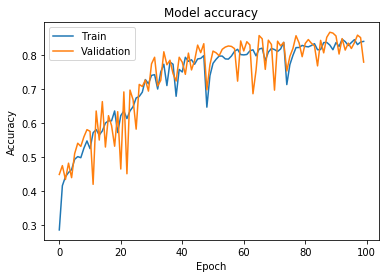

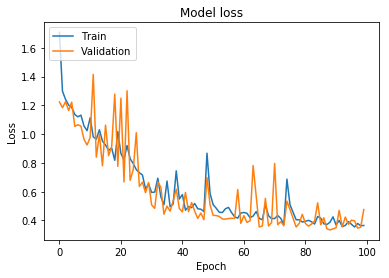

Time for training in seconds: 16562.3501366


In [11]:
config = Config(mode='bi_rnn')

if config.mode == 'conv':
    X, y = build_rand_feat()
    y_flat = np.argmax(y, axis=1) #return the index value
    input_shape = (X.shape[1], X.shape[2], 1)
    t1_start = perf_counter()
    model = get_conv_model()
    
elif config.mode == 'rnn':
    X, y = build_rand_feat()
    y_flat = np.argmax(y, axis=1) #return the index value
    input_shape = (X.shape[1], X.shape[2])
    t1_start = perf_counter()
    model = get_rnn_model()

elif config.mode == 'bi_rnn':
    X, y = build_rand_feat()
    y_flat = np.argmax(y, axis=1) #return the index value
    input_shape = (X.shape[1], X.shape[2])
    t1_start = perf_counter()
    model = get_bi_rnn_model()
    
elif config.mode == 'mlp':
    X, y = build_rand_feat()
    y_flat = np.argmax(y, axis=1) #return the index value
    input_shape = (X.shape[1], X.shape[2])
    t1_start = perf_counter()
    model = get_mlp_model()

class_weight = compute_class_weight('balanced', 
                                    np.unique(y_flat),
                                    y_flat)

checkpoint = ModelCheckpoint(config.model_path, monitor='val_acc', verbose=1, mode='max',
                             save_best_only=True, save_weights_only=False, period=1)

history = model.fit(X, y, epochs=100, batch_size=300, 
          shuffle=True, validation_split=0.1,
          callbacks = [checkpoint])

# Plot training & validation accuracy values
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

model.save(config.model_path)

t1_stop = perf_counter() 
print("Time for training in seconds:", t1_stop-t1_start) 